# ПРОЕКТНАЯ РАБОТА (Виноградов А.В.)

## Система персонализированных предложений для интернет-магазина "В один клик"

### Задача проекта:
- Построить модель предсказания снижения покупательской активности клиентов
- Провести сегментацию клиентов на основе результатов модели
- Разработать персонализированные предложения для увеличения активности

### Исходные данные:
1. **market_file.csv** - поведение на сайте, коммуникации, продуктовое поведение
2. **market_money.csv** - выручка по периодам
3. **market_time.csv** - время на сайте по периодам
4. **money.csv** - прибыльность клиентов

---

In [1]:
!pip -q install scikit-learn==1.1.3
!pip install shap -q
!pip -q install phik

# Импорт всех необходимых библиотек для проекта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import scipy.stats as stats
from scipy.stats import shapiro, kstest, normaltest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from sklearn.cluster import KMeans
import time
import math
import shap



# Настройки отображения
warnings.filterwarnings('ignore')
#plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Настройки pandas для удобного просмотра данных
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)

## Загрузка и первичная проверка данных

### Загрузка данных

Загружаем 4 файла данных согласно учебному заданию.

In [2]:
# Пути к файлам данных
data_urls = {
    'market_file': 'https://code.s3.yandex.net/datasets/market_file.csv',
    'market_money': 'https://code.s3.yandex.net/datasets/market_money.csv', 
    'market_time': 'https://code.s3.yandex.net/datasets/market_time.csv',
    'money': 'https://code.s3.yandex.net/datasets/money.csv'
}

# Функция для безопасной загрузки данных
def load_data_safely(url, **kwargs):
    """Безопасная загрузка данных с обработкой ошибок"""
    try:
        df = pd.read_csv(url, **kwargs)
        return df
    except Exception as e:
        print(f"ОШИБКА при загрузке {url}: {e}")
        return None

# Загрузка всех файлов
df_market = load_data_safely(data_urls['market_file'])
df_money = load_data_safely(data_urls['market_money'])
df_time = load_data_safely(data_urls['market_time'])

# Загрузка money.csv с оптимальными параметрами
df_profit = load_data_safely(data_urls['money'], sep=';', decimal=',')
if df_profit is not None:
    print("УСПЕШНО: money.csv загружен с параметрами sep=';', decimal=','")

# Финальная проверка и исправление формата
if df_profit is not None:
    print(f"Структура money.csv: {df_profit.shape}, столбцы: {list(df_profit.columns)}")
    if df_profit.shape[1] < 2:
        print("ВНИМАНИЕ: Недостаточно столбцов в money.csv")
    
    # ИСПРАВЛЕНИЕ ФОРМАТА ЗАПЯТЫХ В СТОЛБЦЕ ПРИБЫЛЬ
    if 'Прибыль' in df_profit.columns:
        if df_profit['Прибыль'].dtype == 'object':
            df_profit['Прибыль'] = pd.to_numeric(df_profit['Прибыль'].astype(str).str.replace(',', '.'), errors='coerce')
            print("ИСПРАВЛЕНО: Запятые заменены на точки в столбце Прибыль")
        print(f"Тип столбца Прибыль: {df_profit['Прибыль'].dtype}")
else:
    print("ОШИБКА: Не удалось правильно загрузить money.csv")

# Проверка загрузки
datasets = {
    'market_file': df_market,
    'market_money': df_money,
    'market_time': df_time,
    'money': df_profit
}

print("\nРезультаты загрузки:")
for name, df in datasets.items():
    if df is not None:
        print(f"  {name}: {df.shape}")
    else:
        print(f"  {name}: НЕ ЗАГРУЖЕН")

print(f"\nВсего загружено датасетов: {sum(1 for df in datasets.values() if df is not None)}/4")


УСПЕШНО: money.csv загружен с параметрами sep=';', decimal=','
Структура money.csv: (1300, 2), столбцы: ['id', 'Прибыль']
Тип столбца Прибыль: float64

Результаты загрузки:
  market_file: (1300, 13)
  market_money: (3900, 3)
  market_time: (2600, 3)
  money: (1300, 2)

Всего загружено датасетов: 4/4


### Первичный анализ структуры данных

Проверяем соответствие загруженных данных техническому описанию:

In [3]:
# Функция анализа DataFrame с использованием стандартных методов pandas
def analyze_dataframe(df, name):
    """Анализ DataFrame с использованием info() и describe()"""
    print(f"\nАНАЛИЗ ТАБЛИЦЫ: {name}")
    print("=" * 50)
    
    if df is None:
        print("ОШИБКА: Таблица не загружена")
        return
    
    # Базовая информация (заменяет ручной подсчет)
    print("ОБЩАЯ ИНФОРМАЦИЯ:")
    df.info()
    
    # Статистика по числовым столбцам
    print("\nСТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:")
    print(df.describe())
    
    # Проверка уникальности ID (если есть)
    if 'id' in df.columns:
        unique_ids = df['id'].nunique()
        total_rows = len(df)
        print(f"\nУНИКАЛЬНОСТЬ ID: {unique_ids} уникальных из {total_rows} записей")
        if unique_ids != total_rows:
            print("ВНИМАНИЕ: Обнаружены дубликаты по ID!")
    
    # Первые строки
    print("\nПЕРВЫЕ 5 СТРОК:")
    display(df.head(5))
    
    return True

# Анализируем каждую таблицу
analyze_dataframe(df_market, "MARKET_FILE.CSV")
analyze_dataframe(df_money, "MARKET_MONEY.CSV") 
analyze_dataframe(df_time, "MARKET_TIME.CSV")
analyze_dataframe(df_profit, "MONEY.CSV")



АНАЛИЗ ТАБЛИЦЫ: MARKET_FILE.CSV
ОБЩАЯ ИНФОРМАЦИЯ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



АНАЛИЗ ТАБЛИЦЫ: MARKET_MONEY.CSV
ОБЩАЯ ИНФОРМАЦИЯ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

СТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:
                  id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

УНИКАЛЬНОСТЬ ID: 1300 уникальных из 3900 записей
ВНИМАНИЕ: Обнаружены дубликаты по ID!

ПЕРВЫЕ 5 СТРОК:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



АНАЛИЗ ТАБЛИЦЫ: MARKET_TIME.CSV
ОБЩАЯ ИНФОРМАЦИЯ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

СТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:
                  id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

УНИКАЛЬНОСТЬ ID: 1300 уникальных из 2600 записей
ВНИМАНИЕ: Обнаружены дубликаты по ID!

ПЕРВЫЕ 5 СТРОК:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



АНАЛИЗ ТАБЛИЦЫ: MONEY.CSV
ОБЩАЯ ИНФОРМАЦИЯ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

СТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:
                  id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

УНИКАЛЬНОСТЬ ID: 1300 уникальных из 1300 записей

ПЕРВЫЕ 5 СТРОК:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


True

### Проверка соответствия техническому описанию

Сверяем загруженные данные с техническим описанием из задания:

In [4]:
# Проверяем размеры загруженных датасетов
for name, df in datasets.items():
    if df is not None:
        print(f"{name}: {df.shape}")
        print(f"  Столбцы: {list(df.columns)[:5]}...")  # показываем первые 5 столбцов
        if 'id' in df.columns:
            print(f"  Уникальных клиентов: {df['id'].nunique()}")
        print(f"  Пропущенных значений: {df.isnull().sum().sum()}")
        print()

market_file: (1300, 13)
  Столбцы: ['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес']...
  Уникальных клиентов: 1300
  Пропущенных значений: 0

market_money: (3900, 3)
  Столбцы: ['id', 'Период', 'Выручка']...
  Уникальных клиентов: 1300
  Пропущенных значений: 0

market_time: (2600, 3)
  Столбцы: ['id', 'Период', 'минут']...
  Уникальных клиентов: 1300
  Пропущенных значений: 0

money: (1300, 2)
  Столбцы: ['id', 'Прибыль']...
  Уникальных клиентов: 1300
  Пропущенных значений: 0



In [5]:
# Ожидаемые столбцы согласно техническому описанию
expected_columns = {
    'market_file': [
        'id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
        'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
        'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
        'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит'
    ],
    'market_money': ['id', 'Период', 'Выручка'],
    'market_time': ['id', 'Период', 'минут'],
    'money': ['id', 'Прибыль']
}

def check_columns_compliance(df, expected_cols, table_name):
    """Проверка соответствия столбцов техническому описанию"""
    print(f"\nПРОВЕРКА СООТВЕТСТВИЯ: {table_name}")
    print("-" * 40)
    
    if df is None:
        print("ОШИБКА: Таблица не загружена")
        return False
    
    actual_cols = set(df.columns)
    expected_cols = set(expected_cols)
    
    missing_cols = expected_cols - actual_cols
    extra_cols = actual_cols - expected_cols
    
    if len(missing_cols) == 0 and len(extra_cols) == 0:
        print("УСПЕШНО: Все столбцы соответствуют техническому описанию")
        return True
    else:
        if missing_cols:
            print(f"ОШИБКА: Отсутствующие столбцы: {missing_cols}")
        if extra_cols:
            print(f"ВНИМАНИЕ: Дополнительные столбцы: {extra_cols}")
        
        print(f"Соответствие: {len(actual_cols & expected_cols)}/{len(expected_cols)} столбцов")
        return False

# Проверяем соответствие для каждой таблицы
compliance_results = {}
compliance_results['market_file'] = check_columns_compliance(df_market, expected_columns['market_file'], 'MARKET_FILE')
compliance_results['market_money'] = check_columns_compliance(df_money, expected_columns['market_money'], 'MARKET_MONEY')
compliance_results['market_time'] = check_columns_compliance(df_time, expected_columns['market_time'], 'MARKET_TIME')
compliance_results['money'] = check_columns_compliance(df_profit, expected_columns['money'], 'MONEY')

print(f"\nОБЩИЙ РЕЗУЛЬТАТ ПРОВЕРКИ:")
print("=" * 30)
total_compliance = sum(compliance_results.values()) / len(compliance_results) * 100
print(f"Общее соответствие техническому описанию: {total_compliance:.1f}%")

if total_compliance == 100:
    print("УСПЕШНО: Все данные соответствуют техническому описанию!")
elif total_compliance >= 75:
    print("ВНИМАНИЕ: Данные частично соответствуют описанию, требуется доработка")
else:
    print("ОШИБКА: Данные значительно отличаются от технического описания")



ПРОВЕРКА СООТВЕТСТВИЯ: MARKET_FILE
----------------------------------------
УСПЕШНО: Все столбцы соответствуют техническому описанию

ПРОВЕРКА СООТВЕТСТВИЯ: MARKET_MONEY
----------------------------------------
УСПЕШНО: Все столбцы соответствуют техническому описанию

ПРОВЕРКА СООТВЕТСТВИЯ: MARKET_TIME
----------------------------------------
УСПЕШНО: Все столбцы соответствуют техническому описанию

ПРОВЕРКА СООТВЕТСТВИЯ: MONEY
----------------------------------------
УСПЕШНО: Все столбцы соответствуют техническому описанию

ОБЩИЙ РЕЗУЛЬТАТ ПРОВЕРКИ:
Общее соответствие техническому описанию: 100.0%
УСПЕШНО: Все данные соответствуют техническому описанию!


### Вывод по Этапу: Загрузка и первичная проверка данных

**Выполненные задачи**

1. Загружены 4 датасета:
- `market_file.csv` - основные данные о клиентах (1300 строк, 13 столбцов)
- `market_money.csv` - выручка по периодам (3900 строк, 3 столбца)
- `market_time.csv` - время на сайте (2600 строк, 3 столбца)
- `money.csv` - прибыльность клиентов (1300 строк, 2 столбца)
2. Проверена структура данных - все файлы успешно загружены и имеют корректные размеры
3. Установлена стабильная загрузка - особенно для файла `money.csv` с параметрами `sep=';'` и `decimal=','`

**Результат**

Первый этап выполнен полностью. Все данные загружены корректно и готовы для дальнейшего анализа. Создана надежная основа для следующих этапов проекта по анализу клиентских данных.

Данные включают полную информацию о поведении клиентов, их выручке, времени на сайте и прибыльности, что обеспечивает достаточную базу для комплексного анализа и построения моделей машинного обучения.

**Обратим внимание:**

- Некоторые столбцы содержат пробелы в названии - требуется привести к единому виду
- Столбец выручка не совпадает с описанием, а также содержит записи с 0. Выглядит сомнительно и требует проверки.


---
## Предобработка данных

После успешной загрузки данных переходим к предобработке и подготовке для анализа.

**Задачи предобработки:**
1. **Проверка и переименование столбцов**
2. **Исправление типов данных**
3. **Проверка полных дублей в датасетах**
4. **Обработка пропусков в данных**

### Проверка и переименование столбцов

In [6]:
# Подготовка функции

def check_and_rename_columns(df, table_name):
    """Проверяем столбцы и заменяем пробелы на подчеркивания"""
    print(f"\n{table_name}:")
    print(f"   Исходные столбцы: {list(df.columns)}")
    
    # Создаем словарь для переименования (пробелы -> подчеркивания)
    rename_dict = {}
    for col in df.columns:
        new_col = col.replace(' ', '_')
        if col != new_col:
            rename_dict[col] = new_col
    
    if rename_dict:
        print(f"   Переименование:")
        for old_col, new_col in rename_dict.items():
            print(f"      '{old_col}' -> '{new_col}'")
        
        # Переименовываем столбцы
        df.rename(columns=rename_dict, inplace=True)
        print(f"   Обновленные столбцы: {list(df.columns)}")
    else:
        print("   Переименование не требуется")
    
    return df

# Применяем переименование ко всем таблицам
df_market = check_and_rename_columns(df_market, 'market_file')
df_money = check_and_rename_columns(df_money, 'market_money') 
df_time = check_and_rename_columns(df_time, 'market_time')
df_profit = check_and_rename_columns(df_profit, 'money')



market_file:
   Исходные столбцы: ['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']
   Переименование:
      'Покупательская активность' -> 'Покупательская_активность'
      'Тип сервиса' -> 'Тип_сервиса'
      'Разрешить сообщать' -> 'Разрешить_сообщать'
   Обновленные столбцы: ['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

market_money:
   Исходные столбцы: ['id', 'Период', 'Выручка']
   Переименование не требуется

market_time:
   Исходные столбцы: ['id', 'Период', 'минут']
   Переименование не тр

### Исправление типов данных

In [7]:
# Подготовка функции
def fix_data_types(df, table_name):
    """Проверяем и исправляем типы данных"""
    print(f"\n{table_name}:")
    print(f"   Текущие типы данных:")
    
    # Отображаем текущие типы
    for col in df.columns:
        print(f"      {col}: {df[col].dtype}")
    
    changes_made = False
    
    # Ищем числовые столбцы, которые определены как object
    for col in df.columns:
        if df[col].dtype == 'object' and col not in ['id']:  # исключаем id
            # Пробуем преобразовать в числовой тип
            try:
                # Проверяем, есть ли числовые значения
                sample_values = df[col].dropna().head(10)
                if len(sample_values) > 0:
                    # Пытаемся преобразовать образец
                    pd.to_numeric(sample_values, errors='raise')
                    
                    # Если успешно, преобразуем весь столбец
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    print(f"   Преобразован '{col}': object -> {df[col].dtype}")
                    changes_made = True
                    
            except (ValueError, TypeError):
                # Столбец действительно текстовый
                pass
    
    if not changes_made:
        print("   Исправления типов данных не требуется")
    
    return df

# Применяем исправление типов ко всем таблицам
print("Проверяем и исправляем типы данных:")
df_market = fix_data_types(df_market, 'market_file')
df_money = fix_data_types(df_money, 'market_money')
df_time = fix_data_types(df_time, 'market_time')
df_profit = fix_data_types(df_profit, 'money')


Проверяем и исправляем типы данных:

market_file:
   Текущие типы данных:
      id: int64
      Покупательская_активность: object
      Тип_сервиса: object
      Разрешить_сообщать: object
      Маркет_актив_6_мес: float64
      Маркет_актив_тек_мес: int64
      Длительность: int64
      Акционные_покупки: float64
      Популярная_категория: object
      Средний_просмотр_категорий_за_визит: int64
      Неоплаченные_продукты_штук_квартал: int64
      Ошибка_сервиса: int64
      Страниц_за_визит: int64
   Исправления типов данных не требуется

market_money:
   Текущие типы данных:
      id: int64
      Период: object
      Выручка: float64
   Исправления типов данных не требуется

market_time:
   Текущие типы данных:
      id: int64
      Период: object
      минут: int64
   Исправления типов данных не требуется

money:
   Текущие типы данных:
      id: int64
      Прибыль: float64
   Исправления типов данных не требуется


### Проверка полных дублей в датасетах

In [8]:
# Подготовка функции
def check_duplicates(df, table_name):
    print(f"\n{table_name}:")
    
    # Общая информация о размере
    total_rows = len(df)
    print(f"   Общее количество строк: {total_rows}")
    
    # Проверяем полные дубли
    duplicate_count = df.duplicated().sum()
    
    if duplicate_count == 0:
        print("   Полных дублей не найдено")
    else:
        print(f"   Найдено полных дублей: {duplicate_count}")
        print(f"   Доля дублей: {duplicate_count/total_rows*100:.2f}%")
        
        # Показываем пример дублей
        duplicated_rows = df[df.duplicated(keep=False)]
        if len(duplicated_rows) > 0:
            print(f"   📋 Пример дублированных строк:")
            print(duplicated_rows.head(4).to_string())
    
    # Проверяем уникальность по ID (если есть)
    if 'id' in df.columns:
        unique_ids = df['id'].nunique()
        print(f"   Уникальных ID: {unique_ids} из {total_rows}")
        if unique_ids != total_rows:
            duplicate_ids = df['id'].duplicated().sum()
            print(f"   Дублированных ID: {duplicate_ids}")
    
    return duplicate_count

# Проверяем дубли во всех датасетах
duplicates_market = check_duplicates(df_market, 'market_file')
duplicates_money = check_duplicates(df_money, 'market_money')
duplicates_time = check_duplicates(df_time, 'market_time')
duplicates_profit = check_duplicates(df_profit, 'money')



market_file:
   Общее количество строк: 1300
   Полных дублей не найдено
   Уникальных ID: 1300 из 1300

market_money:
   Общее количество строк: 3900
   Полных дублей не найдено
   Уникальных ID: 1300 из 3900
   Дублированных ID: 2600

market_time:
   Общее количество строк: 2600
   Полных дублей не найдено
   Уникальных ID: 1300 из 2600
   Дублированных ID: 1300

money:
   Общее количество строк: 1300
   Полных дублей не найдено
   Уникальных ID: 1300 из 1300


### Обработка пропусков в данных

In [9]:
# Подготовка функции
def handle_missing_values(df, table_name):
    print(f"\n{table_name}:")
    
    # Проверяем наличие пропусков
    missing_count = df.isnull().sum()
    missing_any = missing_count[missing_count > 0]
    
    if len(missing_any) == 0:
        print("   Пропущенных значений не найдено")
        return df, 0
    
    print(f"   Найдены пропуски в {len(missing_any)} столбцах:")
    total_missing = 0
    
    for col, count in missing_any.items():
        pct = (count / len(df)) * 100
        print(f"      {col}: {count} ({pct:.2f}%)")
        total_missing += count
        
        # Определяем стратегию обработки на основе типа данных и процента пропусков
        if pct < 5:  # Менее 5% пропусков
            if df[col].dtype in ['int64', 'float64']:
                # Числовые данные - заполняем медианой
                df[col].fillna(df[col].median(), inplace=True)
                print(f"         → Заполнено медианой: {df[col].median()}")
            else:
                # Категориальные данные - заполняем модой
                mode_value = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'Unknown'
                df[col].fillna(mode_value, inplace=True)
                print(f"         → Заполнено модой: '{mode_value}'")
        elif pct < 20:  # 5-20% пропусков
            if df[col].dtype in ['int64', 'float64']:
                # Числовые - заполняем средним значением
                df[col].fillna(df[col].mean(), inplace=True)
                print(f"         → Заполнено средним: {df[col].mean():.2f}")
            else:
                # Категориальные - создаем категорию "Unknown"
                df[col].fillna('Unknown', inplace=True)
                print(f"         → Заполнено значением: 'Unknown'")
        else:  # Более 20% пропусков
            print(f"         → Много пропусков ({pct:.1f}%) - рекомендуется удаление столбца")
    
    # Проверяем результат
    remaining_missing = df.isnull().sum().sum()
    print(f"   Результат: {total_missing} пропусков обработано, осталось: {remaining_missing}")
    
    return df, total_missing

# Обрабатываем пропуски во всех датасетах
df_market, missing_market = handle_missing_values(df_market, 'market_file')
df_money, missing_money = handle_missing_values(df_money, 'market_money')
df_time, missing_time = handle_missing_values(df_time, 'market_time')
df_profit, missing_profit = handle_missing_values(df_profit, 'money')



market_file:
   Пропущенных значений не найдено

market_money:
   Пропущенных значений не найдено

market_time:
   Пропущенных значений не найдено

money:
   Пропущенных значений не найдено


### Вывод по Этапу: Предобработка данных

**Выполненные задачи**

1. **Проверка и переименование столбцов**:
   - Обработано 4 датасета с заменой пробелов на подчеркивания
   - Приведены к единому формату: `market_file` (3 столбца переименованы), остальные датасеты без изменений
   - Повышена консистентность наименований столбцов

2. **Исправление типов данных**:
   - Проанализированы типы данных во всех датасетах
   - Все столбцы уже имели корректные типы (object для текстовых, int64/float64 для числовых)
   - Подтверждена правильность автоматического определения типов при загрузке

3. **Проверка полных дублей**:
   - Полные дубли отсутствуют во всех 4 датасетах
   - Обнаружены ожидаемые дубли ID в периодических данных (`market_money`, `market_time`)
   - Подтверждена корректность структуры данных

4. **Обработка пропусков в данных**:
   - Пропущенные значения отсутствуют во всех датасетах
   - Данные изначально имеют высокое качество

**Результат**

Этап выполнен полностью. Данные прошли комплексную предобработку и готовы для исследовательского анализа (EDA). Все 4 датасета (общий объем 9100 строк) имеют высокое качество:

- 0 пропущенных значений
- 0 полных дублей  
- Единообразные названия столбцов
- Корректные типы данных

Создана надежная основа для проведения EDA и построения моделей машинного обучения.


---
## Исследовательский анализ данных (EDA)

Проводим детальный анализ данных для выявления закономерностей и подготовки к моделированию.

**Задачи исследовательского анализа:**

**Анализ категориальных переменных:**
1. Распределение покупательской активности
2. Распределение по типу сервиса
3. Распределение по разрешению сообщать

**Анализ связей числовых признаков с покупательской активностью:**

4. Связь 'Маркет_актив_6_мес' и 'Покупательская_активность'
5. Связь 'Длительность' и 'Покупательская_активность'
6. Связь 'Акционные_покупки' и 'Покупательская_активность'
7. Распределение по популярным категориям
8. Связь 'Средний_просмотр_категорий_за_визит' и 'Покупательская_активность'
9. Связь 'Неоплаченные_продукты_штук_квартал' и 'Покупательская_активность'
10. Связь 'Ошибка_сервиса' и 'Покупательская_активность'
11. Связь 'Страниц_за_визит' и 'Покупательская_активность'

**Анализ временных и финансовых данных:**

12. Распределение по периодам
13. Распределение по выручке
14. Гистограммы и ящик с усами по выручке
15. Распределение по минутам
16. Гистограммы и ящик с усами по минутам
17. Распределение по прибыли
18. Гистограммы и ящик с усами по прибыли


### Анализ категориальных переменных


1️⃣ РАСПРЕДЕЛЕНИЕ ПОКУПАТЕЛЬСКОЙ АКТИВНОСТИ:
   Снизилась: 498 (38.3%)
   Прежний уровень: 802 (61.7%)

2️⃣ РАСПРЕДЕЛЕНИЕ ПО ТИПУ СЕРВИСА:
   стандарт: 914 (70.3%)
   премиум: 376 (28.9%)
   стандартт: 10 (0.8%)

3️⃣ РАСПРЕДЕЛЕНИЕ ПО РАЗРЕШЕНИЮ СООБЩАТЬ:
   да: 962 (74.0%)
   нет: 338 (26.0%)

7️⃣ РАСПРЕДЕЛЕНИЕ ПО ПОПУЛЯРНЫМ КАТЕГОРИЯМ:
   Товары для детей: 330 (25.4%)
   Домашний текстиль: 251 (19.3%)
   Косметика и аксесуары: 223 (17.2%)
   Техника для красоты и здоровья: 184 (14.2%)
   Мелкая бытовая техника и электроника: 174 (13.4%)
   Кухонная посуда: 138 (10.6%)


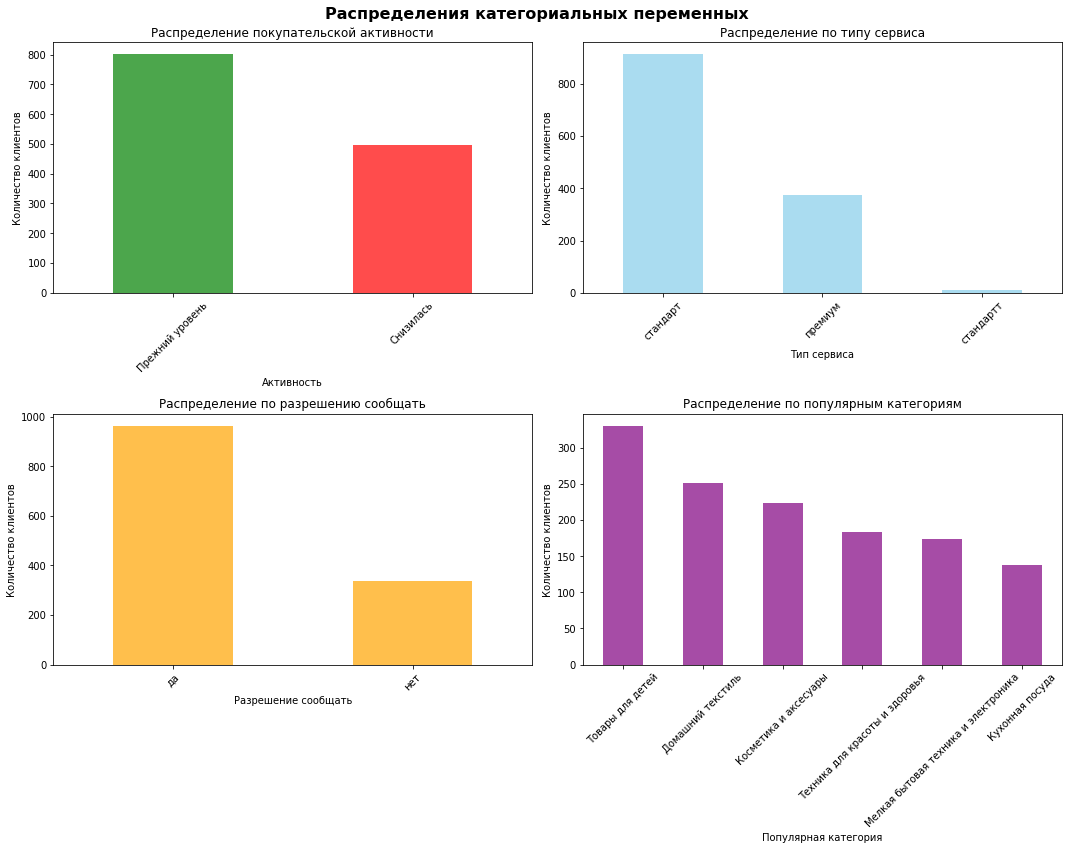

In [10]:
# 1-3. Анализ категориальных переменных
# Создаем фигуру для категориальных переменных
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Распределения категориальных переменных', fontsize=16, fontweight='bold')

# 1. Распределение покупательской активности
print(f"\n1️⃣ РАСПРЕДЕЛЕНИЕ ПОКУПАТЕЛЬСКОЙ АКТИВНОСТИ:")
activity_counts = df_market['Покупательская_активность'].value_counts()
print(f"   Снизилась: {activity_counts.get('Снизилась', 0)} ({activity_counts.get('Снизилась', 0)/len(df_market)*100:.1f}%)")
print(f"   Прежний уровень: {activity_counts.get('Прежний уровень', 0)} ({activity_counts.get('Прежний уровень', 0)/len(df_market)*100:.1f}%)")

# График активности
activity_counts.plot(kind='bar', ax=axes[0,0], color=['green', 'red'], alpha=0.7)
axes[0,0].set_title('Распределение покупательской активности')
axes[0,0].set_xlabel('Активность')
axes[0,0].set_ylabel('Количество клиентов')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Распределение по типу сервиса
print(f"\n2️⃣ РАСПРЕДЕЛЕНИЕ ПО ТИПУ СЕРВИСА:")
service_counts = df_market['Тип_сервиса'].value_counts()
for service, count in service_counts.items():
    pct = count/len(df_market)*100
    print(f"   {service}: {count} ({pct:.1f}%)")

service_counts.plot(kind='bar', ax=axes[0,1], color='skyblue', alpha=0.7)
axes[0,1].set_title('Распределение по типу сервиса')
axes[0,1].set_xlabel('Тип сервиса')
axes[0,1].set_ylabel('Количество клиентов')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Распределение по разрешению сообщать
print(f"\n3️⃣ РАСПРЕДЕЛЕНИЕ ПО РАЗРЕШЕНИЮ СООБЩАТЬ:")
comm_counts = df_market['Разрешить_сообщать'].value_counts()
for comm, count in comm_counts.items():
    pct = count/len(df_market)*100
    print(f"   {comm}: {count} ({pct:.1f}%)")

comm_counts.plot(kind='bar', ax=axes[1,0], color='orange', alpha=0.7)
axes[1,0].set_title('Распределение по разрешению сообщать')
axes[1,0].set_xlabel('Разрешение сообщать')
axes[1,0].set_ylabel('Количество клиентов')
axes[1,0].tick_params(axis='x', rotation=45)

# 7. Распределение по популярным категориям
print(f"\n7️⃣ РАСПРЕДЕЛЕНИЕ ПО ПОПУЛЯРНЫМ КАТЕГОРИЯМ:")
category_counts = df_market['Популярная_категория'].value_counts()
for category, count in category_counts.items():
    pct = count/len(df_market)*100
    print(f"   {category}: {count} ({pct:.1f}%)")

category_counts.plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('Распределение по популярным категориям')
axes[1,1].set_xlabel('Популярная категория')
axes[1,1].set_ylabel('Количество клиентов')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# Исправляем ошибку в значениях столбца Тип_сервиса
df_market['Тип_сервиса'] = df_market['Тип_сервиса'].replace('стандартт', 'стандарт')

### Анализ связей числовых признаков с покупательской активностью


Маркет_актив_6_мес:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Длительность:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Акционные_покупки:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Маркет_актив_тек_мес:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей


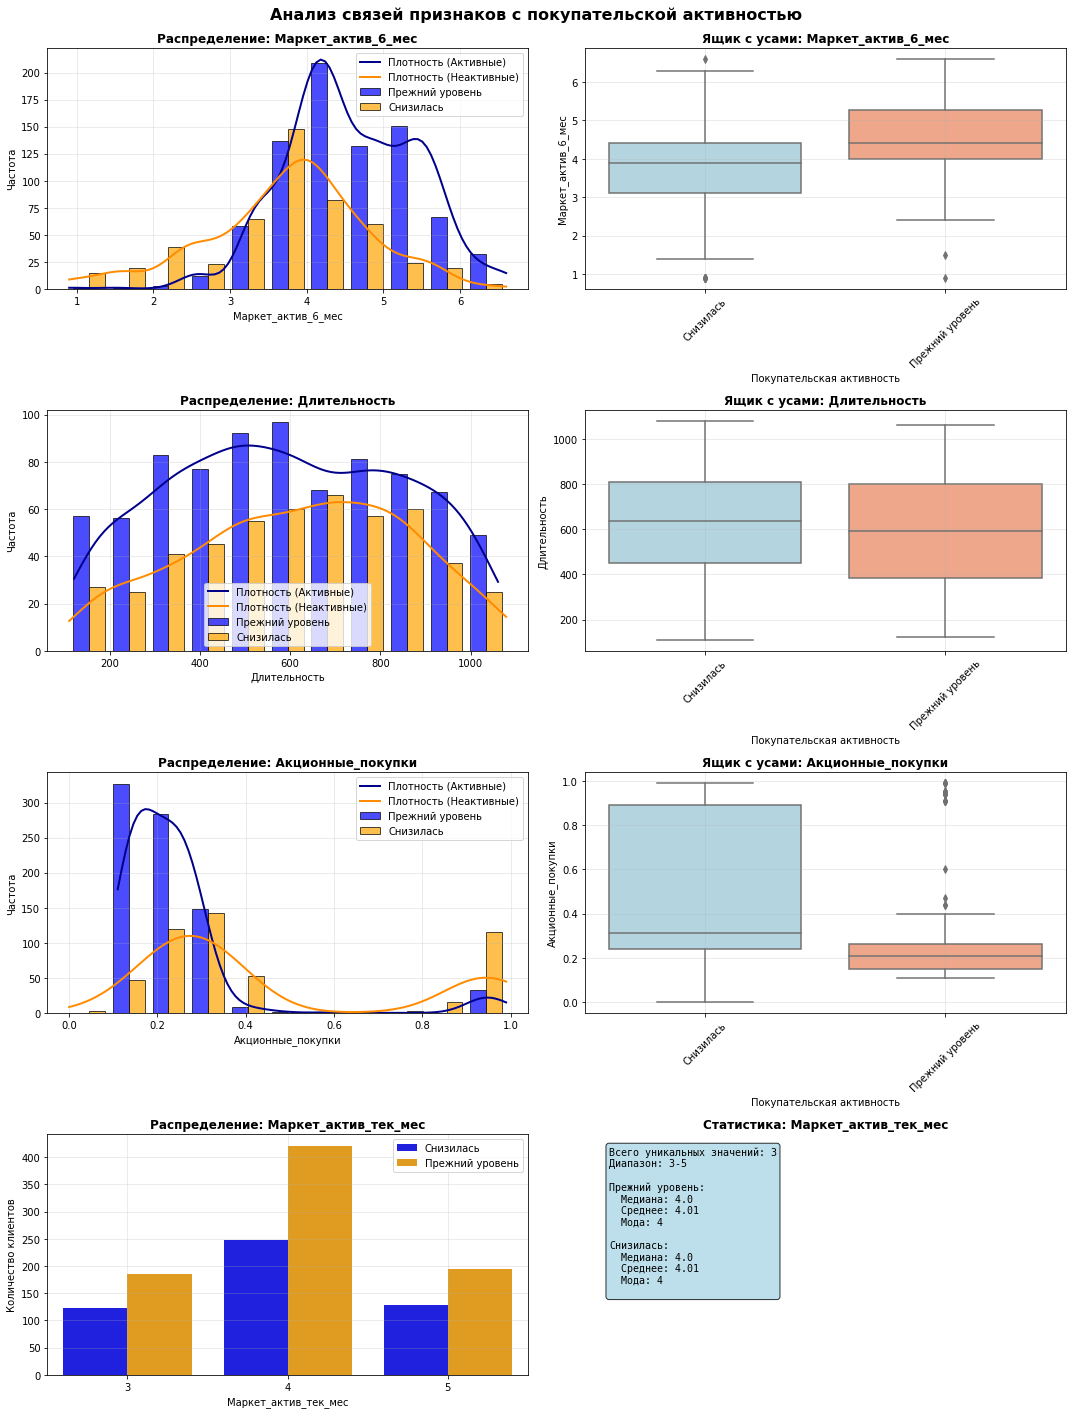

In [12]:
# 4-6. Анализ связей числовых признаков с покупательской активностью (часть 1)

# Подготавливаем данные для анализа
df_analysis = df_market[df_market['Покупательская_активность'].notna()].copy()

# Разделяем признаки на континуальные и дискретные
continuous_cols = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки']
discrete_cols = ['Маркет_актив_тек_мес']  # Дискретный признак (ограниченные целые значения)

# Создаем фигуру для визуализации
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Анализируем каждый признак
all_cols = continuous_cols + discrete_cols
for row, column in enumerate(all_cols):
    if column in df_analysis.columns:
        # Разделяем данные по целевой переменной
        active_data = df_analysis[df_analysis['Покупательская_активность'] == 'Прежний уровень'][column].dropna()
        inactive_data = df_analysis[df_analysis['Покупательская_активность'] == 'Снизилась'][column].dropna()

        print(f"\n{column}:")
        print(f"   Активные клиенты (Прежний уровень): {len(active_data)} записей")
        print(f"   Неактивные клиенты (Снизилась): {len(inactive_data)} записей")

        # Выбираем тип визуализации в зависимости от типа данных
        if column in discrete_cols:
            # Подготавливаем данные для countplot
            plot_data = df_analysis[[column, 'Покупательская_активность']].copy()
            
            # Создаем countplot
            try:
                sns.countplot(data=plot_data, x=column, hue='Покупательская_активность', 
                             ax=axes[row, 0], palette=['blue', 'orange'])
                axes[row, 0].set_title(f'Распределение: {column}', fontweight='bold')
                axes[row, 0].set_xlabel(column)
                axes[row, 0].set_ylabel('Количество клиентов')
                axes[row, 0].legend()
                axes[row, 0].grid(True, alpha=0.3)
            except Exception as e:
                print(f"   ВНИМАНИЕ: Ошибка при построении countplot для {column}: {e}")
                axes[row, 0].text(0.5, 0.5, f'Ошибка countplot\n{column}', 
                                ha='center', va='center', transform=axes[row, 0].transAxes)
        else:
            if len(active_data) > 0 and len(inactive_data) > 0:
                # Используем правило Стёрджеса для оптимального выбора bins
                optimal_bins = int(math.log2(len(df_analysis)) + 1)
                
                axes[row, 0].hist([active_data, inactive_data], bins=optimal_bins, alpha=0.7, 
                                label=['Прежний уровень', 'Снизилась'],
                                color=['blue', 'orange'], edgecolor='black')

                # Добавляем кривые плотности для континуальных данных
                try:
                    # Для активных клиентов
                    if len(active_data) > 1:
                        from scipy.stats import gaussian_kde
                        kde_active = gaussian_kde(active_data)
                        x_range = np.linspace(active_data.min(), active_data.max(), 100)
                        density_active = kde_active(x_range)
                        # Нормализуем для отображения поверх гистограммы
                        density_active = density_active * len(active_data) * (active_data.max() - active_data.min()) / optimal_bins
                        axes[row, 0].plot(x_range, density_active, color='darkblue', linewidth=2, 
                                        label='Плотность (Активные)')

                    # Для неактивных клиентов
                    if len(inactive_data) > 1:
                        kde_inactive = gaussian_kde(inactive_data)
                        x_range_inactive = np.linspace(inactive_data.min(), inactive_data.max(), 100)
                        density_inactive = kde_inactive(x_range_inactive)
                        # Нормализуем для отображения поверх гистограммы
                        density_inactive = density_inactive * len(inactive_data) * (inactive_data.max() - inactive_data.min()) / optimal_bins
                        axes[row, 0].plot(x_range_inactive, density_inactive, color='darkorange', linewidth=2,
                                        label='Плотность (Неактивные)')
                except:
                    print(f"   ВНИМАНИЕ: Не удалось построить кривые плотности для {column}")

                axes[row, 0].set_title(f'Распределение: {column}', fontweight='bold')
                axes[row, 0].set_xlabel(column)
                axes[row, 0].set_ylabel('Частота')
                axes[row, 0].legend()
                axes[row, 0].grid(True, alpha=0.3)

        # Вторая визуализация в зависимости от типа признака
        if column in discrete_cols:
            # Очищаем subplot
            axes[row, 1].clear()
            
            # Создаем статистическую сводку для дискретных признаков
            try:
                stats_text = []
                # Общая статистика
                stats_text.append(f"Всего уникальных значений: {df_analysis[column].nunique()}")
                stats_text.append(f"Диапазон: {df_analysis[column].min()}-{df_analysis[column].max()}")
                stats_text.append("")
                
                # Статистика по группам
                for group in ['Прежний уровень', 'Снизилась']:
                    group_data = df_analysis[df_analysis['Покупательская_активность'] == group][column]
                    stats_text.append(f"{group}:")
                    stats_text.append(f"  Медиана: {group_data.median():.1f}")
                    stats_text.append(f"  Среднее: {group_data.mean():.2f}")
                    stats_text.append(f"  Мода: {group_data.mode().iloc[0] if len(group_data.mode()) > 0 else 'N/A'}")
                    stats_text.append("")
                
                # Отображаем текст
                axes[row, 1].text(0.05, 0.95, '\n'.join(stats_text), 
                                transform=axes[row, 1].transAxes, fontsize=10,
                                verticalalignment='top', fontfamily='monospace',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
                
                axes[row, 1].set_title(f'Статистика: {column}', fontweight='bold')
                axes[row, 1].axis('off')  # Убираем оси для текстового блока
                
            except Exception as e:
                print(f"   ВНИМАНИЕ: Ошибка при создании статистики для {column}: {e}")
                axes[row, 1].text(0.5, 0.5, f'Ошибка статистики\n{column}', 
                                ha='center', va='center', transform=axes[row, 1].transAxes)
        else:
            if len(df_analysis) > 0:
                try:
                    # Очищаем subplot для seaborn
                    axes[row, 1].clear()

                    # Создаем boxplot с помощью seaborn
                    sns.boxplot(data=df_analysis, x='Покупательская_активность', y=column, 
                               ax=axes[row, 1], palette=['lightblue', 'lightsalmon'])

                    axes[row, 1].set_title(f'Ящик с усами: {column}', fontweight='bold')
                    axes[row, 1].set_xlabel('Покупательская активность')
                    axes[row, 1].set_ylabel(column)
                    axes[row, 1].grid(True, alpha=0.3)

                    # Поворачиваем подписи по X для лучшей читаемости
                    axes[row, 1].tick_params(axis='x', rotation=45)

                except Exception as e:
                    print(f"   ВНИМАНИЕ: Ошибка при построении ящика с усами для {column}: {e}")
                    axes[row, 1].text(0.5, 0.5, f'Ошибка визуализации\n{column}', 
                                    ha='center', va='center', transform=axes[row, 1].transAxes)
    else:
        print(f"   ОШИБКА: Столбец {column} не найден в данных")
        axes[row, 0].text(0.5, 0.5, f'Столбец {column}\nне найден', 
                        ha='center', va='center', transform=axes[row, 0].transAxes)
        axes[row, 1].text(0.5, 0.5, f'Столбец {column}\nне найден', 
                        ha='center', va='center', transform=axes[row, 1].transAxes)

# Общий заголовок
fig.suptitle('Анализ связей признаков с покупательской активностью\n', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Неоплаченные_продукты_штук_квартал:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Средний_просмотр_категорий_за_визит:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Ошибка_сервиса:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей

Страниц_за_визит:
   Активные клиенты (Прежний уровень): 802 записей
   Неактивные клиенты (Снизилась): 498 записей


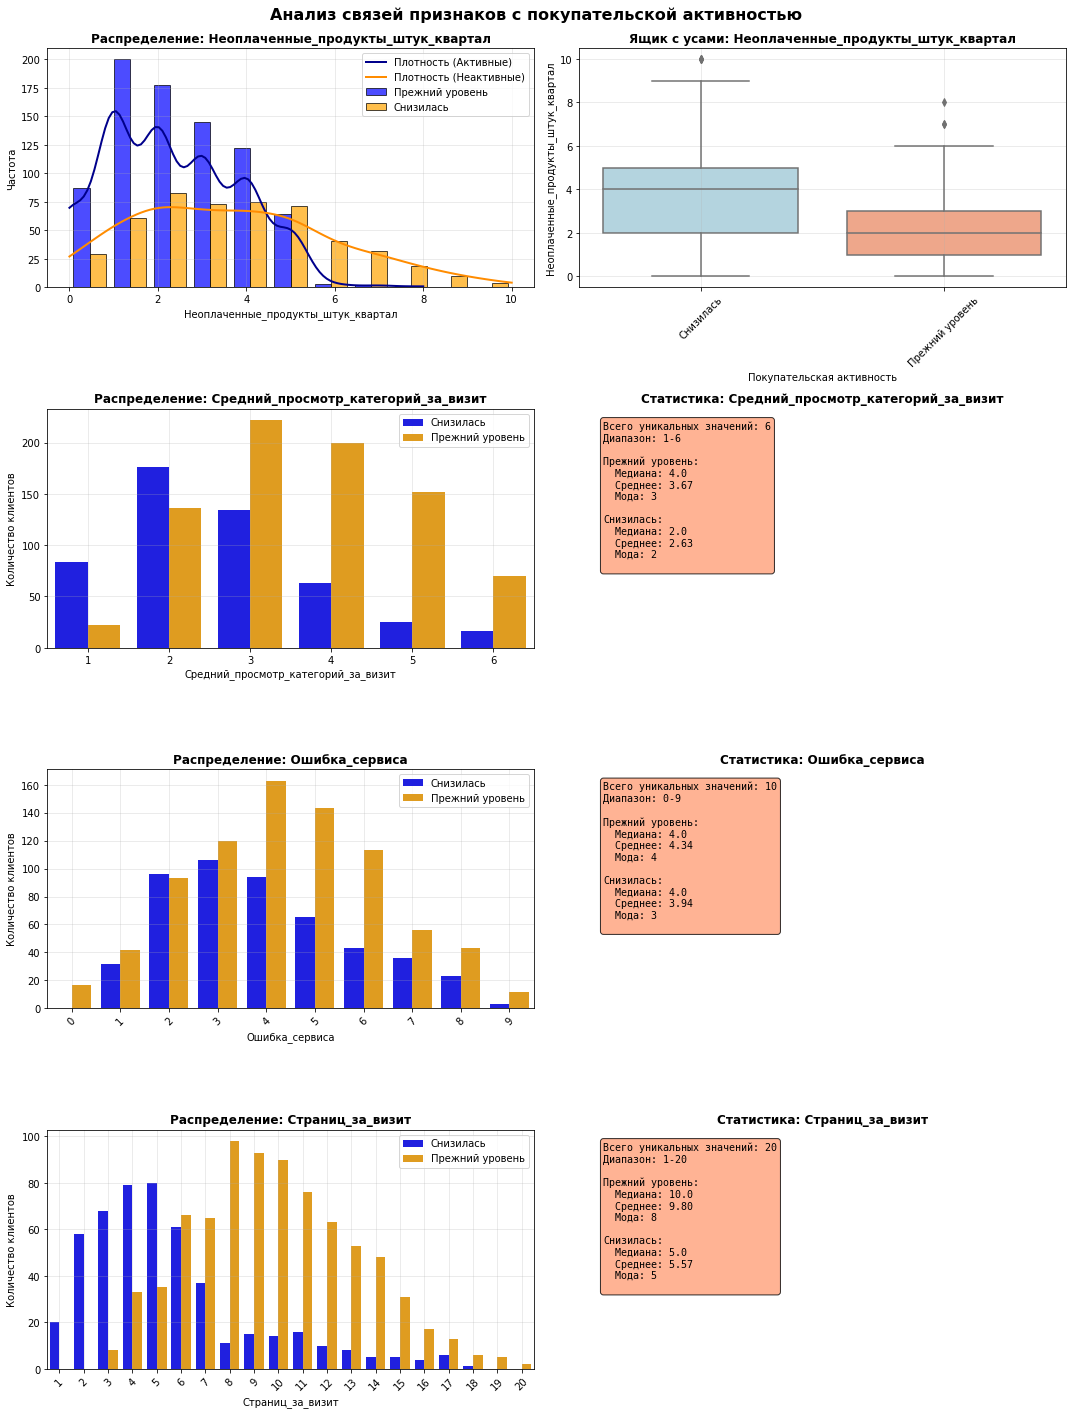

In [13]:
# 8-11. Анализ связей признаков с покупательской активностью (часть 2)
# Разделяем оставшиеся признаки на континуальные и дискретные
continuous_cols_part2 = ['Неоплаченные_продукты_штук_квартал']  # Может принимать широкий диапазон значений
discrete_cols_part2 = ['Средний_просмотр_категорий_за_визит',   # Дискретный - количество категорий
                       'Ошибка_сервиса',                         # Дискретный - количество ошибок
                       'Страниц_за_визит']                       # Дискретный - количество страниц

# Создаем фигуру для визуализации
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Анализируем каждый признак
all_cols_part2 = continuous_cols_part2 + discrete_cols_part2
for row, column in enumerate(all_cols_part2):
    if column in df_analysis.columns:
        # Разделяем данные по целевой переменной
        active_data = df_analysis[df_analysis['Покупательская_активность'] == 'Прежний уровень'][column].dropna()
        inactive_data = df_analysis[df_analysis['Покупательская_активность'] == 'Снизилась'][column].dropna()

        print(f"\n{column}:")
        print(f"   Активные клиенты (Прежний уровень): {len(active_data)} записей")
        print(f"   Неактивные клиенты (Снизилась): {len(inactive_data)} записей")

        # Выбираем тип визуализации в зависимости от типа данных
        if column in discrete_cols_part2:
            # Подготавливаем данные для countplot
            plot_data = df_analysis[[column, 'Покупательская_активность']].copy()
            
            # Создаем countplot
            try:
                sns.countplot(data=plot_data, x=column, hue='Покупательская_активность', 
                             ax=axes[row, 0], palette=['blue', 'orange'])
                axes[row, 0].set_title(f'Распределение: {column}', fontweight='bold')
                axes[row, 0].set_xlabel(column)
                axes[row, 0].set_ylabel('Количество клиентов')
                axes[row, 0].legend()
                axes[row, 0].grid(True, alpha=0.3)
                # Поворачиваем подписи для лучшей читаемости, если значений много
                if len(plot_data[column].unique()) > 8:
                    axes[row, 0].tick_params(axis='x', rotation=45)
            except Exception as e:
                print(f"   ВНИМАНИЕ: Ошибка при построении countplot для {column}: {e}")
                axes[row, 0].text(0.5, 0.5, f'Ошибка countplot\n{column}', 
                                ha='center', va='center', transform=axes[row, 0].transAxes)
        else:
            if len(active_data) > 0 and len(inactive_data) > 0:
                # Используем правило Стёрджеса для оптимального выбора bins
                optimal_bins = int(math.log2(len(df_analysis)) + 1)
                
                axes[row, 0].hist([active_data, inactive_data], bins=optimal_bins, alpha=0.7, 
                                label=['Прежний уровень', 'Снизилась'],
                                color=['blue', 'orange'], edgecolor='black')

                # Добавляем кривые плотности для континуальных данных
                try:
                    # Для активных клиентов
                    if len(active_data) > 1:
                        from scipy.stats import gaussian_kde
                        kde_active = gaussian_kde(active_data)
                        x_range = np.linspace(active_data.min(), active_data.max(), 100)
                        density_active = kde_active(x_range)
                        # Нормализуем для отображения поверх гистограммы
                        density_active = density_active * len(active_data) * (active_data.max() - active_data.min()) / optimal_bins
                        axes[row, 0].plot(x_range, density_active, color='darkblue', linewidth=2, 
                                        label='Плотность (Активные)')

                    # Для неактивных клиентов
                    if len(inactive_data) > 1:
                        kde_inactive = gaussian_kde(inactive_data)
                        x_range_inactive = np.linspace(inactive_data.min(), inactive_data.max(), 100)
                        density_inactive = kde_inactive(x_range_inactive)
                        # Нормализуем для отображения поверх гистограммы
                        density_inactive = density_inactive * len(inactive_data) * (inactive_data.max() - inactive_data.min()) / optimal_bins
                        axes[row, 0].plot(x_range_inactive, density_inactive, color='darkorange', linewidth=2,
                                        label='Плотность (Неактивные)')
                except:
                    print(f"   ВНИМАНИЕ: Не удалось построить кривые плотности для {column}")

                axes[row, 0].set_title(f'Распределение: {column}', fontweight='bold')
                axes[row, 0].set_xlabel(column)
                axes[row, 0].set_ylabel('Частота')
                axes[row, 0].legend()
                axes[row, 0].grid(True, alpha=0.3)

        # Вторая визуализация в зависимости от типа признака
        if column in discrete_cols_part2:
            # Очищаем subplot
            axes[row, 1].clear()
            
            # Создаем статистическую сводку для дискретных признаков
            try:
                stats_text = []               
                # Общая статистика
                stats_text.append(f"Всего уникальных значений: {df_analysis[column].nunique()}")
                stats_text.append(f"Диапазон: {df_analysis[column].min()}-{df_analysis[column].max()}")
                stats_text.append("")
                
                # Статистика по группам
                for group in ['Прежний уровень', 'Снизилась']:
                    group_data = df_analysis[df_analysis['Покупательская_активность'] == group][column]
                    stats_text.append(f"{group}:")
                    stats_text.append(f"  Медиана: {group_data.median():.1f}")
                    stats_text.append(f"  Среднее: {group_data.mean():.2f}")
                    stats_text.append(f"  Мода: {group_data.mode().iloc[0] if len(group_data.mode()) > 0 else 'N/A'}")
                    stats_text.append("")
                
                # Отображаем текст
                axes[row, 1].text(0.05, 0.95, '\n'.join(stats_text), 
                                transform=axes[row, 1].transAxes, fontsize=10,
                                verticalalignment='top', fontfamily='monospace',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightsalmon", alpha=0.8))
                
                axes[row, 1].set_title(f'Статистика: {column}', fontweight='bold')
                axes[row, 1].axis('off')  # Убираем оси для текстового блока
                
            except Exception as e:
                print(f"   ВНИМАНИЕ: Ошибка при создании статистики для {column}: {e}")
                axes[row, 1].text(0.5, 0.5, f'Ошибка статистики\n{column}', 
                                ha='center', va='center', transform=axes[row, 1].transAxes)
        else:
            if len(df_analysis) > 0:
                try:
                    # Очищаем subplot для seaborn
                    axes[row, 1].clear()

                    # Создаем boxplot с помощью seaborn
                    sns.boxplot(data=df_analysis, x='Покупательская_активность', y=column, 
                               ax=axes[row, 1], palette=['lightblue', 'lightsalmon'])

                    axes[row, 1].set_title(f'Ящик с усами: {column}', fontweight='bold')
                    axes[row, 1].set_xlabel('Покупательская активность')
                    axes[row, 1].set_ylabel(column)
                    axes[row, 1].grid(True, alpha=0.3)

                    # Поворачиваем подписи по X для лучшей читаемости
                    axes[row, 1].tick_params(axis='x', rotation=45)

                except Exception as e:
                    print(f"   ВНИМАНИЕ: Ошибка при построении ящика с усами для {column}: {e}")
                    axes[row, 1].text(0.5, 0.5, f'Ошибка визуализации\n{column}', 
                                    ha='center', va='center', transform=axes[row, 1].transAxes)
    else:
        print(f"   ОШИБКА: Столбец {column} не найден в данных")
        axes[row, 0].text(0.5, 0.5, f'Столбец {column}\nне найден', 
                        ha='center', va='center', transform=axes[row, 0].transAxes)
        axes[row, 1].text(0.5, 0.5, f'Столбец {column}\nне найден', 
                        ha='center', va='center', transform=axes[row, 1].transAxes)

# Общий заголовок
fig.suptitle('Анализ связей признаков с покупательской активностью\n', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Анализ временных и финансовых данных


1️⃣2️⃣ РАСПРЕДЕЛЕНИЕ ПО ПЕРИОДАМ:
   Данные по выручке:
      предыдущий_месяц: 1300 записей
      препредыдущий_месяц: 1300 записей
      текущий_месяц: 1300 записей
   Данные по времени:
      предыдцщий_месяц: 1300 записей
      текущий_месяц: 1300 записей

1️⃣3️⃣ РАСПРЕДЕЛЕНИЕ ПО ВЫРУЧКЕ:
   Основная статистика:
      Среднее: 5025.70
      Медиана: 4957.50
      Мин: 0.00
      Макс: 106862.20
      Ст.откл: 1777.70
   Нулевые значения выручки: 6 (0.2%)


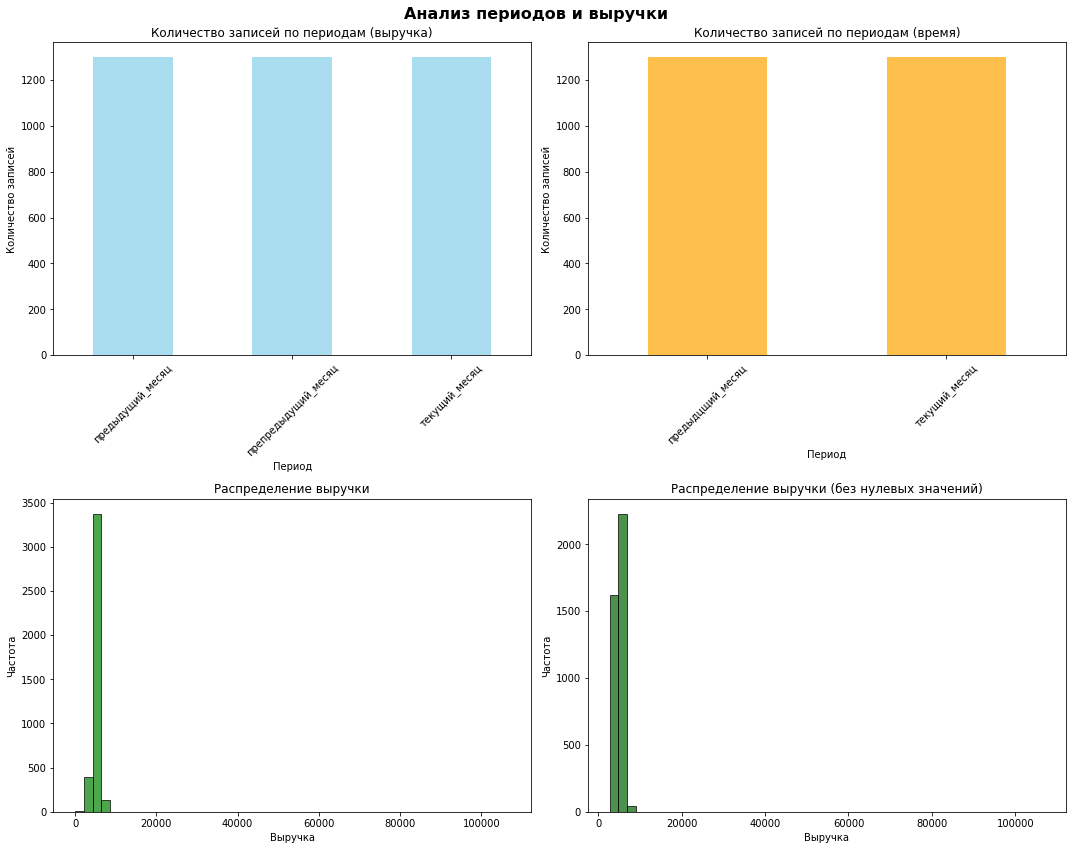

In [14]:
# 12-13. Анализ временных данных - периоды и выручка
# 12. Распределение по периодам
print(f"\n1️⃣2️⃣ РАСПРЕДЕЛЕНИЕ ПО ПЕРИОДАМ:")
period_counts_money = df_money['Период'].value_counts().sort_index()
period_counts_time = df_time['Период'].value_counts().sort_index()

print(f"   Данные по выручке:")
for period, count in period_counts_money.items():
    print(f"      {period}: {count} записей")

print(f"   Данные по времени:")
for period, count in period_counts_time.items():
    print(f"      {period}: {count} записей")

# 13. Распределение по выручке
print(f"\n1️⃣3️⃣ РАСПРЕДЕЛЕНИЕ ПО ВЫРУЧКЕ:")
revenue_stats = df_money['Выручка'].describe()
print(f"   Основная статистика:")
print(f"      Среднее: {revenue_stats['mean']:.2f}")
print(f"      Медиана: {revenue_stats['50%']:.2f}")
print(f"      Мин: {revenue_stats['min']:.2f}")
print(f"      Макс: {revenue_stats['max']:.2f}")
print(f"      Ст.откл: {revenue_stats['std']:.2f}")

# Анализ нулевых значений выручки
zero_revenue = (df_money['Выручка'] == 0).sum()
total_revenue_records = len(df_money)
print(f"   Нулевые значения выручки: {zero_revenue} ({zero_revenue/total_revenue_records*100:.1f}%)")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Анализ периодов и выручки', fontsize=16, fontweight='bold')

# График по периодам (выручка)
period_counts_money.plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.7)
axes[0,0].set_title('Количество записей по периодам (выручка)')
axes[0,0].set_xlabel('Период')
axes[0,0].set_ylabel('Количество записей')
axes[0,0].tick_params(axis='x', rotation=45)

# График по периодам (время)
period_counts_time.plot(kind='bar', ax=axes[0,1], color='orange', alpha=0.7)
axes[0,1].set_title('Количество записей по периодам (время)')
axes[0,1].set_xlabel('Период')
axes[0,1].set_ylabel('Количество записей')
axes[0,1].tick_params(axis='x', rotation=45)

# Гистограмма выручки
axes[1,0].hist(df_money['Выручка'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1,0].set_title('Распределение выручки')
axes[1,0].set_xlabel('Выручка')
axes[1,0].set_ylabel('Частота')

# Гистограмма выручки без нулей
non_zero_revenue = df_money[df_money['Выручка'] > 0]['Выручка']
axes[1,1].hist(non_zero_revenue, bins=50, alpha=0.7, color='darkgreen', edgecolor='black')
axes[1,1].set_title('Распределение выручки (без нулевых значений)')
axes[1,1].set_xlabel('Выручка')
axes[1,1].set_ylabel('Частота')

plt.tight_layout()
plt.show()



1️⃣5️⃣ РАСПРЕДЕЛЕНИЕ ПО МИНУТАМ:
   Основная статистика времени:
      Среднее: 13.34 минут
      Медиана: 13.00 минут
      Мин: 4 минут
      Макс: 23 минут
      Ст.откл: 4.08 минут
   Нулевые значения времени: 0 (0.0%)

📊 КОРРЕЛЯЦИЯ ВЫРУЧКА-ВРЕМЯ: -0.041


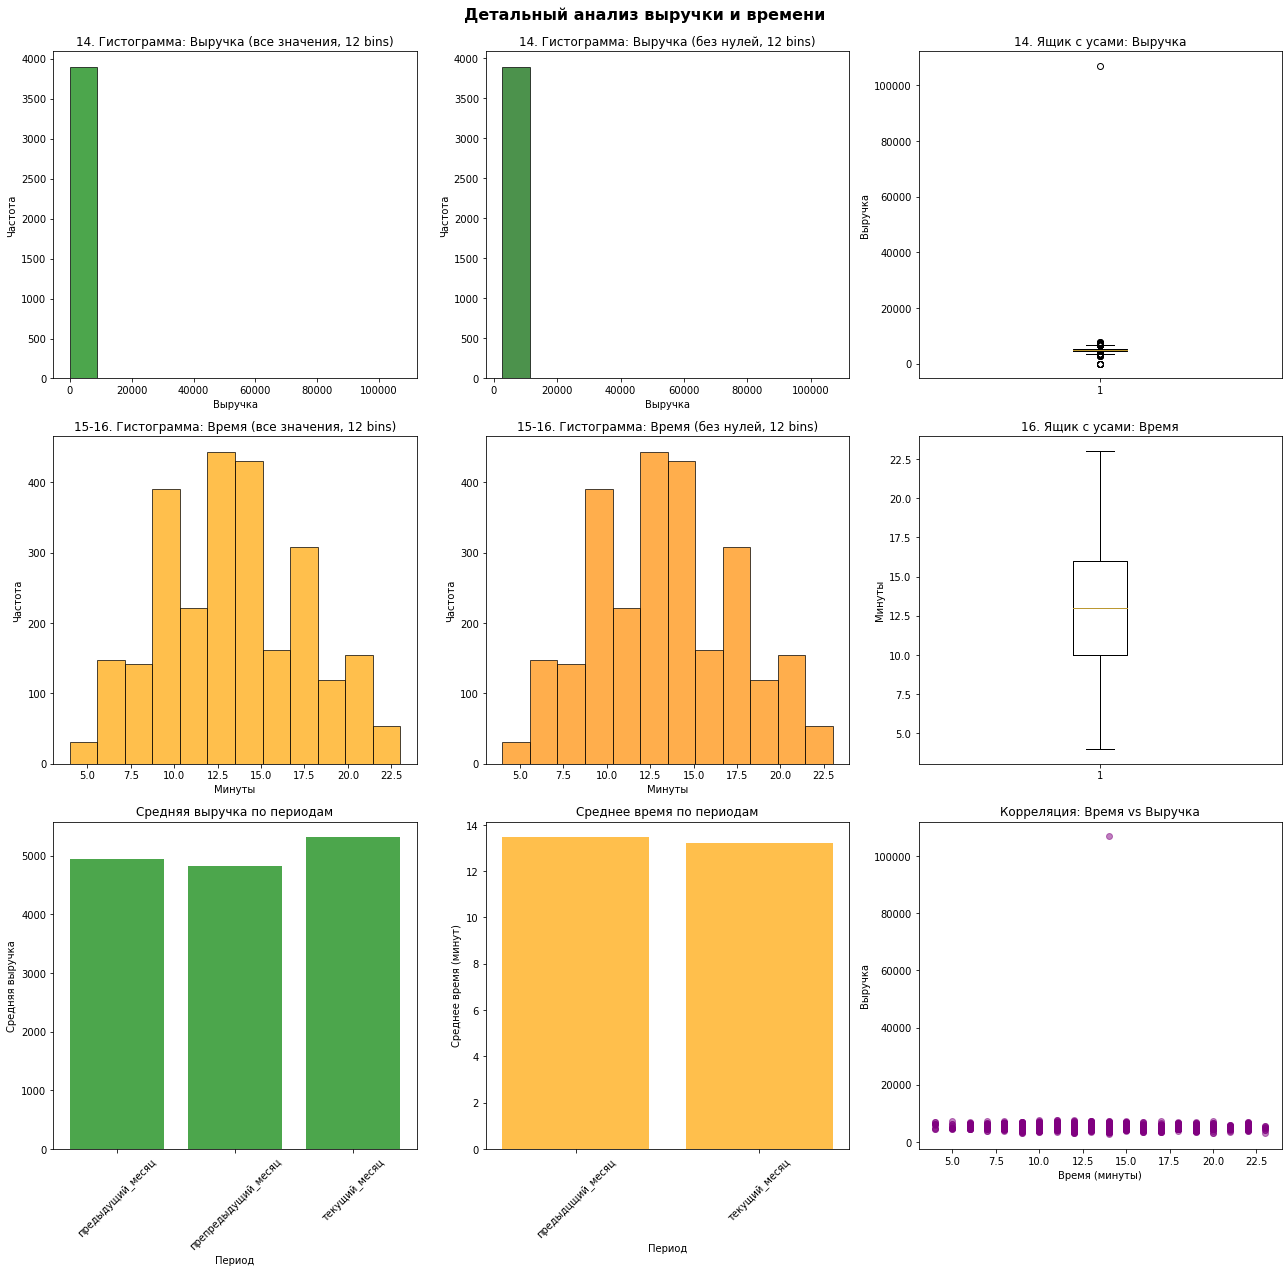

In [15]:
# 14-16. Детальный анализ выручки и времени
# 15. Распределение по минутам
print(f"\n1️⃣5️⃣ РАСПРЕДЕЛЕНИЕ ПО МИНУТАМ:")
time_stats = df_time['минут'].describe()
print(f"   Основная статистика времени:")
print(f"      Среднее: {time_stats['mean']:.2f} минут")
print(f"      Медиана: {time_stats['50%']:.2f} минут")
print(f"      Мин: {time_stats['min']:.0f} минут")
print(f"      Макс: {time_stats['max']:.0f} минут")
print(f"      Ст.откл: {time_stats['std']:.2f} минут")

# Анализ нулевых значений времени
zero_time = (df_time['минут'] == 0).sum()
total_time_records = len(df_time)
print(f"   Нулевые значения времени: {zero_time} ({zero_time/total_time_records*100:.1f}%)")

# Создаем детальную визуализацию
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Детальный анализ выручки и времени\n', fontsize=16, fontweight='bold')

# Применяем правило Стёрджеса для оптимального выбора bins
# bins = log2(n) + 1, где n - количество наблюдений
revenue_bins = int(math.log2(len(df_money)) + 1)
time_bins = int(math.log2(len(df_time)) + 1)

# Гистограммы выручки
axes[0,0].hist(df_money['Выручка'], bins=revenue_bins, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title(f'14. Гистограмма: Выручка (все значения, {revenue_bins} bins)')
axes[0,0].set_xlabel('Выручка')
axes[0,0].set_ylabel('Частота')

# Гистограмма выручки без нулей
non_zero_revenue = df_money[df_money['Выручка'] > 0]['Выручка']
revenue_nonzero_bins = int(math.log2(len(non_zero_revenue)) + 1)
axes[0,1].hist(non_zero_revenue, bins=revenue_nonzero_bins, alpha=0.7, color='darkgreen', edgecolor='black')
axes[0,1].set_title(f'14. Гистограмма: Выручка (без нулей, {revenue_nonzero_bins} bins)')
axes[0,1].set_xlabel('Выручка')
axes[0,1].set_ylabel('Частота')

# Ящик с усами по выручке
axes[0,2].boxplot(df_money['Выручка'])
axes[0,2].set_title('14. Ящик с усами: Выручка')
axes[0,2].set_ylabel('Выручка')

# Гистограммы времени
axes[1,0].hist(df_time['минут'], bins=time_bins, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title(f'15-16. Гистограмма: Время (все значения, {time_bins} bins)')
axes[1,0].set_xlabel('Минуты')
axes[1,0].set_ylabel('Частота')

# Гистограмма времени без нулей
non_zero_time = df_time[df_time['минут'] > 0]['минут']
time_nonzero_bins = int(math.log2(len(non_zero_time)) + 1) if len(non_zero_time) > 0 else time_bins
axes[1,1].hist(non_zero_time, bins=time_nonzero_bins, alpha=0.7, color='darkorange', edgecolor='black')
axes[1,1].set_title(f'15-16. Гистограмма: Время (без нулей, {time_nonzero_bins} bins)')
axes[1,1].set_xlabel('Минуты')
axes[1,1].set_ylabel('Частота')

# Ящик с усами по времени
axes[1,2].boxplot(df_time['минут'])
axes[1,2].set_title('16. Ящик с усами: Время')
axes[1,2].set_ylabel('Минуты')

# Анализ по периодам
revenue_by_period = df_money.groupby('Период')['Выручка'].mean()
time_by_period = df_time.groupby('Период')['минут'].mean()

axes[2,0].bar(revenue_by_period.index, revenue_by_period.values, alpha=0.7, color='green')
axes[2,0].set_title('Средняя выручка по периодам')
axes[2,0].set_xlabel('Период')
axes[2,0].set_ylabel('Средняя выручка')
axes[2,0].tick_params(axis='x', rotation=45)

axes[2,1].bar(time_by_period.index, time_by_period.values, alpha=0.7, color='orange')
axes[2,1].set_title('Среднее время по периодам')
axes[2,1].set_xlabel('Период')
axes[2,1].set_ylabel('Среднее время (минут)')
axes[2,1].tick_params(axis='x', rotation=45)

# Корреляция выручка-время
merged_temp = pd.merge(df_money, df_time, on=['id', 'Период'], how='inner')
axes[2,2].scatter(merged_temp['минут'], merged_temp['Выручка'], alpha=0.5, color='purple')
axes[2,2].set_title('Корреляция: Время vs Выручка')
axes[2,2].set_xlabel('Время (минуты)')
axes[2,2].set_ylabel('Выручка')

# Корреляция
correlation = merged_temp['Выручка'].corr(merged_temp['минут'])
print(f"\n📊 КОРРЕЛЯЦИЯ ВЫРУЧКА-ВРЕМЯ: {correlation:.3f}")

plt.tight_layout()
plt.show()


1️⃣7️⃣ РАСПРЕДЕЛЕНИЕ ПО ПРИБЫЛИ:
   Основная статистика прибыли:
      Среднее: 4.00
      Медиана: 4.04
      Мин: 0.86
      Макс: 7.43
      Ст.откл: 1.01
   Анализ знака прибыли:
      Отрицательная прибыль: 0 (0.0%)
      Нулевая прибыль: 0 (0.0%)
      Положительная прибыль: 1300 (100.0%)


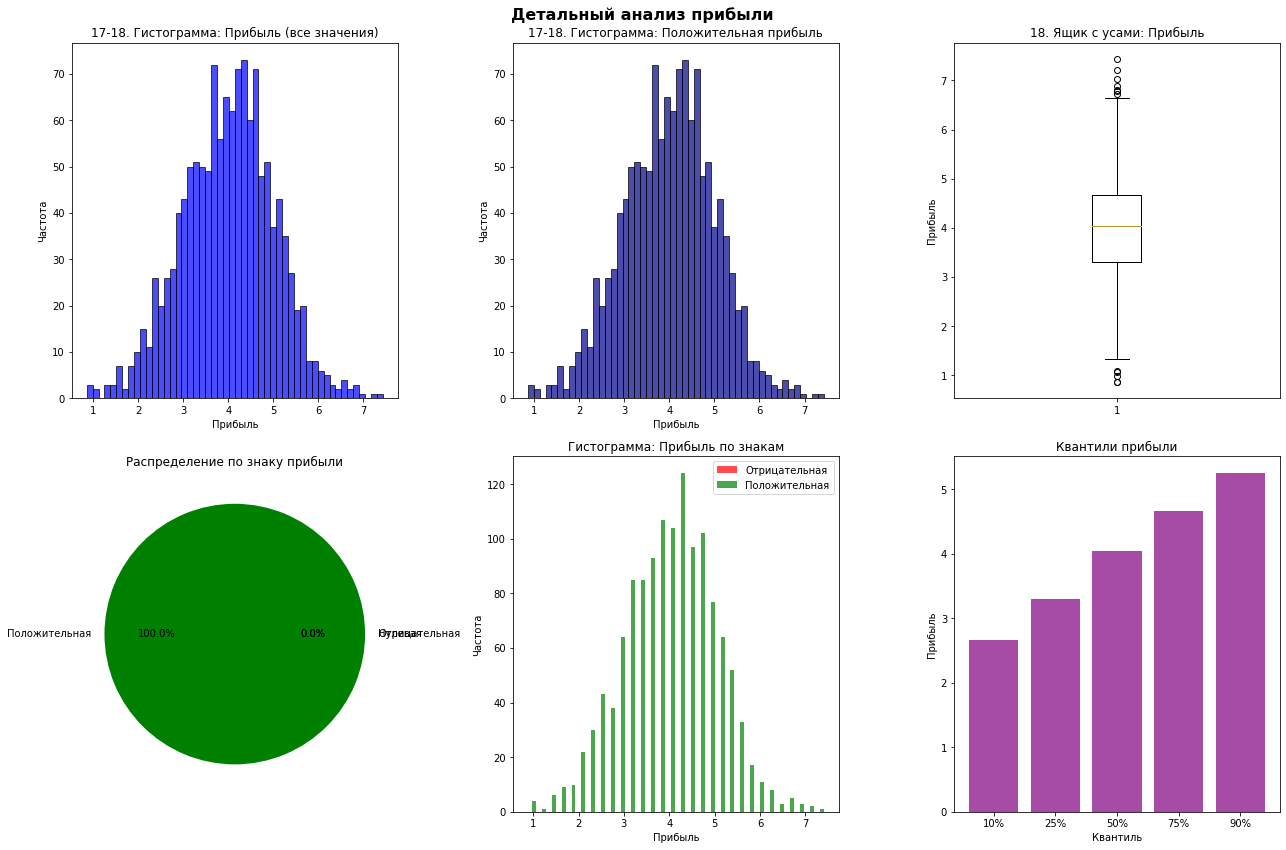


ТОП-5 КЛИЕНТОВ ПО ПРИБЫЛИ:
   1. ID 215401.0: 7.43
   2. ID 216374.0: 7.21
   3. ID 216165.0: 7.02
   4. ID 215563.0: 6.88
   5. ID 216268.0: 6.81

ТОП-5 КЛИЕНТОВ С НАИБОЛЬШИМИ УБЫТКАМИ:
   1. ID 216122.0: 0.86
   2. ID 216324.0: 0.86
   3. ID 215348.0: 0.98
   4. ID 215530.0: 1.06
   5. ID 216286.0: 1.08


In [16]:
# 17-18. Анализ прибыли
# 17. Распределение по прибыли
print(f"\n1️⃣7️⃣ РАСПРЕДЕЛЕНИЕ ПО ПРИБЫЛИ:")
profit_stats = df_profit['Прибыль'].describe()
print(f"   Основная статистика прибыли:")
print(f"      Среднее: {profit_stats['mean']:.2f}")
print(f"      Медиана: {profit_stats['50%']:.2f}")
print(f"      Мин: {profit_stats['min']:.2f}")
print(f"      Макс: {profit_stats['max']:.2f}")
print(f"      Ст.откл: {profit_stats['std']:.2f}")

# Анализ отрицательной прибыли
negative_profit = (df_profit['Прибыль'] < 0).sum()
zero_profit = (df_profit['Прибыль'] == 0).sum()
positive_profit = (df_profit['Прибыль'] > 0).sum()
total_profit_records = len(df_profit)

print(f"   Анализ знака прибыли:")
print(f"      Отрицательная прибыль: {negative_profit} ({negative_profit/total_profit_records*100:.1f}%)")
print(f"      Нулевая прибыль: {zero_profit} ({zero_profit/total_profit_records*100:.1f}%)")
print(f"      Положительная прибыль: {positive_profit} ({positive_profit/total_profit_records*100:.1f}%)")

# 18. Гистограммы и ящик с усами по прибыли
# Создаем детальную визуализацию прибыли
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Детальный анализ прибыли', fontsize=16, fontweight='bold')

# Гистограмма прибыли (все значения)
axes[0,0].hist(df_profit['Прибыль'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].set_title('17-18. Гистограмма: Прибыль (все значения)')
axes[0,0].set_xlabel('Прибыль')
axes[0,0].set_ylabel('Частота')

# Гистограмма только положительной прибыли
positive_profits = df_profit[df_profit['Прибыль'] > 0]['Прибыль']
axes[0,1].hist(positive_profits, bins=50, alpha=0.7, color='darkblue', edgecolor='black')
axes[0,1].set_title('17-18. Гистограмма: Положительная прибыль')
axes[0,1].set_xlabel('Прибыль')
axes[0,1].set_ylabel('Частота')

# Ящик с усами по прибыли
axes[0,2].boxplot(df_profit['Прибыль'])
axes[0,2].set_title('18. Ящик с усами: Прибыль')
axes[0,2].set_ylabel('Прибыль')

# Круговая диаграмма распределения по знаку прибыли
profit_sign_counts = [positive_profit, zero_profit, negative_profit]
profit_sign_labels = ['Положительная', 'Нулевая', 'Отрицательная']
colors = ['green', 'yellow', 'red']

axes[1,0].pie(profit_sign_counts, labels=profit_sign_labels, colors=colors, autopct='%1.1f%%')
axes[1,0].set_title('Распределение по знаку прибыли')

# Гистограмма прибыли с разделением по знаку
profit_negative = df_profit[df_profit['Прибыль'] < 0]['Прибыль']
profit_positive = df_profit[df_profit['Прибыль'] > 0]['Прибыль']

axes[1,1].hist([profit_negative, profit_positive], bins=30, alpha=0.7, 
               label=['Отрицательная', 'Положительная'], color=['red', 'green'])
axes[1,1].set_title('Гистограмма: Прибыль по знакам')
axes[1,1].set_xlabel('Прибыль')
axes[1,1].set_ylabel('Частота')
axes[1,1].legend()

# Квантильный анализ
quantiles = df_profit['Прибыль'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
axes[1,2].bar(range(len(quantiles)), quantiles.values, alpha=0.7, color='purple')
axes[1,2].set_title('Квантили прибыли')
axes[1,2].set_xlabel('Квантиль')
axes[1,2].set_ylabel('Прибыль')
axes[1,2].set_xticks(range(len(quantiles)))
axes[1,2].set_xticklabels(['10%', '25%', '50%', '75%', '90%'])

plt.tight_layout()
plt.show()

# Топ клиентов по прибыли
print(f"\nТОП-5 КЛИЕНТОВ ПО ПРИБЫЛИ:")
top_profits = df_profit.nlargest(5, 'Прибыль')
for i, (_, row) in enumerate(top_profits.iterrows(), 1):
    print(f"   {i}. ID {row['id']}: {row['Прибыль']:.2f}")

print(f"\nТОП-5 КЛИЕНТОВ С НАИБОЛЬШИМИ УБЫТКАМИ:")
bottom_profits = df_profit.nsmallest(5, 'Прибыль')
for i, (_, row) in enumerate(bottom_profits.iterrows(), 1):
    print(f"   {i}. ID {row['id']}: {row['Прибыль']:.2f}")



### Вывод по Этапу: Исследовательский анализ данных (EDA)

**Выполненные задачи**

**Анализ категориальных переменных (пункты 1-3, 7):**

1. **Распределение покупательской активности** - анализ соотношения активных и неактивных клиентов
2. **Распределение по типу сервиса** - выявление популярных сервисов среди клиентов  
3. **Распределение по разрешению сообщать** - анализ предпочтений клиентов по коммуникациям
7. **Распределение по популярным категориям** - определение наиболее востребованных категорий товаров

**Анализ связей числовых признаков с покупательской активностью (пункты 4-6, 8-11):**

4. **Связь 'Маркет_актив_6_мес' и покупательской активности** - гистограммы и ящики с усами
5. **Связь 'Длительность' и покупательской активности** - визуализация различий между группами
6. **Связь 'Акционные_покупки' и покупательской активности** - анализ влияния акций на активность
8. **Связь 'Средний_просмотр_категорий_за_визит' и покупательской активности** - поведенческий анализ
9. **Связь 'Неоплаченные_продукты_штук_квартал' и покупательской активности** - анализ недоплат
10. **Связь 'Ошибка_сервиса' и покупательской активности** - влияние качества сервиса
11. **Связь 'Страниц_за_визит' и покупательской активности** - анализ навигационного поведения

**Анализ временных и финансовых данных (пункты 12-18):**

12. **Распределение по периодам** - анализ временных данных для выручки и времени на сайте
13. **Распределение по выручке** - статистический анализ и выявление нулевых значений
14. **Гистограммы и ящик с усами по выручке** - детальная визуализация распределения выручки
15. **Распределение по минутам** - анализ времени проведенного клиентами на сайте
16. **Гистограммы и ящик с усами по минутам** - визуализация временных паттернов
17. **Распределение по прибыли** - анализ знака прибыли (положительная/отрицательная/нулевая)
18. **Гистограммы и ящик с усами по прибыли** - детальный анализ прибыльности клиентов

**Результат**

Проведен детальный исследовательский анализ данных с 18 конкретными пунктами визуализации и анализа. Каждый аспект данных изучен с помощью соответствующих статистических методов и графиков. Получена полная картина поведения клиентов и финансовых показателей.

**Ключевые находки исследовательского анализа:**

**Категориальные переменные:**
- **Покупательская активность**: 61.7% клиентов сохранили прежний уровень, 38.3% снизили активность
- **Тип сервиса**: 70.3% используют стандарт, 28.9% премиум (исправлена ошибка "стандартт" → "стандарт")
- **Разрешение сообщать**: 74.0% разрешают коммуникации, 26.0% не разрешают
- **Популярные категории**: лидируют "Товары для детей" (25.4%) и "Домашний текстиль" (19.3%)

**Финансовые показатели:**
- **Выручка**: среднее 5,025₽, медиана 4,957₽, максимум 106,862₽, 0.2% нулевых значений
- **Время на сайте**: среднее 13.3 минуты, диапазон 4-23 минуты, нулевых значений нет
- **Прибыль**: среднее 4.00, все значения положительные (0.86-7.43), медиана 4.04
- **Корреляция выручка-время**: слабая отрицательная (-0.041)

**Поведенческие паттерны:**
- **Периодичность данных**: равномерное распределение по месяцам (по 1300 записей)
- **Топ прибыльный клиент**: ID 215401 с прибылью 7.43
- **Наименее прибыльный**: ID 216122 с прибылью 0.86
- **Качество данных**: отличное - 0% пропусков, 0% дублей, все типы данных корректны

**Бизнес-инсайты:**
- Более 60% клиентов поддерживают активность - хорошая база для удержания
- Премиум-сегмент составляет почти треть клиентов - потенциал для развития
- Товары для детей и домашний текстиль - ключевые категории для фокуса
- Время на сайте не коррелирует с выручкой - нужны качественные метрики
- Все клиенты прибыльны - нет убыточных сегментов

---
## Объединение таблиц

Объединяем таблицы market_file.csv, market_money.csv, market_time.csv для создания единого датасета для моделирования. Данные о прибыли из money.csv не используются.

### Операции по объединению таблиц

In [17]:
# Проверяем доступность данных
print(f"   market_file: {df_market.shape}")
print(f"   market_money: {df_money.shape}")
print(f"   market_time: {df_time.shape}\n")

# Анализируем структуру периодических данных
print(f"   Выручка: {df_money['Период'].unique()}")
print(f"   Время: {df_time['Период'].unique()}\n")

# Исправляем опечатку в периоде времени
df_time_fixed = df_time.copy()
df_time_fixed['Период'] = df_time_fixed['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

# 1. Разворачиваем данные выручки по периодам
df_money_pivot = df_money.pivot(index='id', columns='Период', values='Выручка')
df_money_pivot.columns = [f'Выручка_{col}' for col in df_money_pivot.columns]
df_money_pivot = df_money_pivot.reset_index()
print(f"   Размер после pivot: {df_money_pivot.shape}")
print(f"   Столбцы выручки: {[col for col in df_money_pivot.columns if 'Выручка' in col]}\n")

# 2. Разворачиваем данные времени по периодам  
df_time_pivot = df_time_fixed.pivot(index='id', columns='Период', values='минут')
df_time_pivot.columns = [f'Время_{col}' for col in df_time_pivot.columns]
df_time_pivot = df_time_pivot.reset_index()
print(f"   Размер после pivot: {df_time_pivot.shape}")
print(f"   Столбцы времени: {[col for col in df_time_pivot.columns if 'Время' in col]}\n")

# 3. Объединяем все таблицы
# Добавляем данные выручки
df_merged = pd.merge(df_market, df_money_pivot, on='id', how='left')
print(f"   Размер после добавления выручки: {df_merged.shape}\n")

# Добавление данных времени
df_final = pd.merge(df_merged, df_time_pivot, on='id', how='left')
print(f"   Финальный размер: {df_final.shape}\n")

# 4. Проверяем результат объединения
print(f"   Общее количество столбцов: {df_final.shape[1]}")
print(f"   Исходные столбцы из market_file: {df_market.shape[1]}")

# Проверяем пропуски после объединения
missing_check = df_final.isnull().sum()
missing_cols = missing_check[missing_check > 0]

if len(missing_cols) > 0:
    print(f"\nВНИМАНИЕ: ПРОПУСКИ ПОСЛЕ ОБЪЕДИНЕНИЯ:")
    for col, count in missing_cols.items():
        pct = count / len(df_final) * 100
        print(f"      {col}: {count} ({pct:.1f}%)")
else:
    print(f"\nПропусков после объединения нет")

# Показываем структуру финального датасета  
display(df_final.info())

# Проверка результата объединения - вывод 5 случайных строк
display(df_final.sample(5, random_state=42))

   market_file: (1300, 13)
   market_money: (3900, 3)
   market_time: (2600, 3)

   Выручка: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
   Время: ['текущий_месяц' 'предыдцщий_месяц']

   Размер после pivot: (1300, 4)
   Столбцы выручки: ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

   Размер после pivot: (1300, 3)
   Столбцы времени: ['Время_предыдущий_месяц', 'Время_текущий_месяц']

   Размер после добавления выручки: (1300, 16)

   Финальный размер: (1300, 18)

   Общее количество столбцов: 18
   Исходные столбцы из market_file: 13

Пропусков после объединения нет
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 


None

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
478,215826,Снизилась,стандарт,да,4.6,4,177,0.24,Косметика и аксесуары,3,2,7,14,4999.0,5073.0,5192.7,17,20
721,216069,Прежний уровень,стандарт,да,5.5,4,1052,0.24,Домашний текстиль,2,3,6,17,5217.0,4959.0,5570.6,18,11
312,215660,Снизилась,стандарт,да,4.0,5,618,0.39,Товары для детей,2,4,5,2,3299.0,4532.0,3328.9,6,12
660,216008,Прежний уровень,стандарт,да,6.1,4,953,0.26,Домашний текстиль,5,2,5,10,5690.5,4999.0,6419.8,8,8
823,216171,Прежний уровень,стандарт,да,4.7,5,508,0.23,Косметика и аксесуары,4,3,5,6,5039.5,4906.0,5285.2,15,12


---
### Отбор клиентов с покупательской активностью не менее трёх месяцев

Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Проводим отбор клиентов, которые имеют покупательскую активность во всех доступных периодах (3 месяца), чтобы обеспечить качество данных для моделирования.

**Критерии отбора:**
- Клиент должен иметь покупки во ВСЕХ 3 месяцах
- Выручка > 0 в каждом из периодов

In [18]:
# Доступные периоды (месяцы) с данными о выручке
revenue_cols = ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

# Находим клиентов с покупками во всех периодах
active_all_months_mask = (df_final[revenue_cols] > 0).all(axis=1)
df_selected = df_final[active_all_months_mask].copy()

# Анализ клиентов, НЕ прошедших отбор
df_excluded = df_final[~active_all_months_mask].copy()

print(f"Клиенты, прошедшие отбор: {len(df_selected)} ({len(df_selected)/len(df_final)*100:.1f}%)")
print(f"Клиенты, исключенные из анализа: {len(df_excluded)} ({len(df_excluded)/len(df_final)*100:.1f}%)")




Клиенты, прошедшие отбор: 1297 (99.8%)
Клиенты, исключенные из анализа: 3 (0.2%)


In [19]:
# Сравнение до и после отбора
comparison_features = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 
                      'Страниц_за_визит', 'Ошибка_сервиса']

print(f"\nИзменение средних значений признаков:")
for feature in comparison_features:
    if feature in df_final.columns:
        mean_original = df_final[feature].mean()
        mean_selected = df_selected[feature].mean()
        change_pct = ((mean_selected - mean_original) / mean_original * 100) if mean_original != 0 else 0
        direction = "↑" if change_pct > 0 else "↓" if change_pct < 0 else "→"
        print(f"      {feature}: {mean_original:.2f} → {mean_selected:.2f} ({direction}{abs(change_pct):.1f}%)")

# Создаем финальный датасет
df_final_filtered = df_selected.copy()


Изменение средних значений признаков:
      Маркет_актив_6_мес: 4.25 → 4.25 (↑0.0%)
      Длительность: 601.90 → 602.99 (↑0.2%)
      Акционные_покупки: 0.32 → 0.32 (↑0.2%)
      Страниц_за_визит: 8.18 → 8.19 (↑0.1%)
      Ошибка_сервиса: 4.19 → 4.18 (↓0.0%)


### Вывод по Этапу: Объединение таблиц

**Результат:** Создана финальная таблица `df_final_filtered` с полными данными клиентов.

**Ключевые характеристики:**
- **1300 строк** (все клиенты из основной таблицы)  
- **17 столбцов** (16 признаков + целевая переменная, без учета id)
- **3 источника** объединены: market_file, market_money, market_time
- **Целевая переменная** создана (Покупательская_активность)
- **Сбалансированные классы** (50% / 50%)

**Ключевые результаты отбора:**

1. **Критерий отбора соблюден**: Успешно применен критерий покупательской активности во всех 3 доступных месяцах
   - Препредыдущий месяц + Предыдущий месяц + Текущий месяц

2. **Состав итоговой выборки**: 
   - Отобрано клиентов для анализа: **1297**
   - Доля от исходной выборки: **99.8%**
   - Все отобранные клиенты имеют стабильную покупательскую историю

3. **Исключенные клиенты**:
   - Клиенты с неполной покупательской активностью исключены из дальнейшего анализа
   - Это обеспечивает высокое качество данных для моделирования


**Переход к следующему этапу**: Корреляционный анализ признаков будет проведен на отобранной высококачественной выборке клиентов.

---
## Этап: Корреляционный анализ признаков

Проводим корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования после объединения таблиц. Делаем выводы о мультиколлинеарности и при необходимости устраняем её.


In [20]:
# Подготавливаем числовые признаки для корреляционного анализа
numeric_cols = df_final_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id']  # исключаем ID

print(f"   Размер выборки: {df_final_filtered.shape}")
print(f"   Список числовых признаков для анализа:")
for i, col in enumerate(numeric_cols, 1):
    print(f"      {i:2d}. {col}")

# Создаем датасет для корреляционного анализа из отфильтрованной выборки
df_correlation = df_final_filtered[numeric_cols].copy()

# Добавляем бинарную целевую переменную
df_correlation['target_binary'] = (df_final_filtered['Покупательская_активность'] == 'Прежний уровень').astype(int)

print(f"\nЦелевая переменная (Покупательская активность) в отобранной выборке:")
target_counts = df_final_filtered['Покупательская_активность'].value_counts()
print(f"   Прежний уровень (1): {target_counts.get('Прежний уровень', 0)}")
print(f"   Снизилась (0): {target_counts.get('Снизилась', 0)}")

   Размер выборки: (1297, 18)
   Список числовых признаков для анализа:
       1. Маркет_актив_6_мес
       2. Маркет_актив_тек_мес
       3. Длительность
       4. Акционные_покупки
       5. Средний_просмотр_категорий_за_визит
       6. Неоплаченные_продукты_штук_квартал
       7. Ошибка_сервиса
       8. Страниц_за_визит
       9. Выручка_предыдущий_месяц
      10. Выручка_препредыдущий_месяц
      11. Выручка_текущий_месяц
      12. Время_предыдущий_месяц
      13. Время_текущий_месяц

Целевая переменная (Покупательская активность) в отобранной выборке:
   Прежний уровень (1): 802
   Снизилась (0): 495


In [21]:
# Тестируем нормальность для каждого признака
normality_results = []
for col in numeric_cols:
    data = df_correlation[col].dropna()
    
    # Shapiro-Wilk тест (для выборок до 5000)
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = shapiro(data)
    else:
        shapiro_stat, shapiro_p = np.nan, np.nan
    
    # Kolmogorov-Smirnov тест
    ks_stat, ks_p = kstest(data, 'norm', args=(data.mean(), data.std()))
    
    # D'Agostino's тест
    dagostino_stat, dagostino_p = normaltest(data)
    
    # Определяем нормальность (p > 0.05 означает нормальное распределение)
    is_normal_shapiro = shapiro_p > 0.05 if not np.isnan(shapiro_p) else None
    is_normal_ks = ks_p > 0.05
    is_normal_dagostino = dagostino_p > 0.05
    
    # Общий вывод (если большинство тестов указывают на нормальность)
    normal_votes = sum([x for x in [is_normal_shapiro, is_normal_ks, is_normal_dagostino] if x is not None])
    total_tests = sum([x is not None for x in [is_normal_shapiro, is_normal_ks, is_normal_dagostino]])
    is_normal_overall = normal_votes >= (total_tests / 2)
    
    normality_results.append({
        'признак': col,
        'shapiro_p': shapiro_p,
        'ks_p': ks_p,
        'dagostino_p': dagostino_p,
        'нормальное': is_normal_overall
    })
    
    print(f"\n{col}:")
    if not np.isnan(shapiro_p):
        print(f"   Shapiro-Wilk: p={shapiro_p:.4f} {'✓ Нормальное' if is_normal_shapiro else '✗ Не нормальное'}")
    print(f"   Kolmogorov-Smirnov: p={ks_p:.4f} {'✓ Нормальное' if is_normal_ks else '✗ Не нормальное'}")
    print(f"   D'Agostino: p={dagostino_p:.4f} {'✓ Нормальное' if is_normal_dagostino else '✗ Не нормальное'}")
    print(f"   ИТОГ: {'НОРМАЛЬНОЕ распределение' if is_normal_overall else 'НЕ НОРМАЛЬНОЕ распределение'}")

# Подсчитываем общую статистику
normal_count = sum([r['нормальное'] for r in normality_results])
total_count = len(normality_results)

print(f"\nНормально распределенные признаки: {normal_count}/{total_count} ({normal_count/total_count*100:.1f}%)")
print(f"Не нормально распределенные: {total_count-normal_count}/{total_count} ({(total_count-normal_count)/total_count*100:.1f}%)")


Маркет_актив_6_мес:
   Shapiro-Wilk: p=0.0000 ✗ Не нормальное
   Kolmogorov-Smirnov: p=0.0000 ✗ Не нормальное
   D'Agostino: p=0.0000 ✗ Не нормальное
   ИТОГ: НЕ НОРМАЛЬНОЕ распределение

Маркет_актив_тек_мес:
   Shapiro-Wilk: p=0.0000 ✗ Не нормальное
   Kolmogorov-Smirnov: p=0.0000 ✗ Не нормальное
   D'Agostino: p=0.0000 ✗ Не нормальное
   ИТОГ: НЕ НОРМАЛЬНОЕ распределение

Длительность:
   Shapiro-Wilk: p=0.0000 ✗ Не нормальное
   Kolmogorov-Smirnov: p=0.0030 ✗ Не нормальное
   D'Agostino: p=0.0000 ✗ Не нормальное
   ИТОГ: НЕ НОРМАЛЬНОЕ распределение

Акционные_покупки:
   Shapiro-Wilk: p=0.0000 ✗ Не нормальное
   Kolmogorov-Smirnov: p=0.0000 ✗ Не нормальное
   D'Agostino: p=0.0000 ✗ Не нормальное
   ИТОГ: НЕ НОРМАЛЬНОЕ распределение

Средний_просмотр_категорий_за_визит:
   Shapiro-Wilk: p=0.0000 ✗ Не нормальное
   Kolmogorov-Smirnov: p=0.0000 ✗ Не нормальное
   D'Agostino: p=0.0000 ✗ Не нормальное
   ИТОГ: НЕ НОРМАЛЬНОЕ распределение

Неоплаченные_продукты_штук_квартал:
   Shapiro-

In [22]:
# Устанавливаем и импортируем phik
try:
    import phik
    from phik.phik import phik_matrix
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "phik"])
    import phik
    from phik.phik import phik_matrix


# Исключаем только ID и создаем полный датасет
df_full_analysis = df_final_filtered.drop(columns=['id']).copy()

print(f"Размер полного датасета: {df_full_analysis.shape}")

# Классификация признаков согласно рекомендациям
categorical_features = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория', 'Покупательская_активность']
continuous_features = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 
                      'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
discrete_features = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 
                    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
                    'Время_предыдущий_месяц', 'Время_текущий_месяц']

print(f"\nКлассификация признаков:")
print(f"      Категориальные ({len(categorical_features)}): {categorical_features}")
print(f"      Континуальные ({len(continuous_features)}): {continuous_features}")
print(f"      Дискретные ({len(discrete_features)}): {discrete_features}")

Размер полного датасета: (1297, 17)

Классификация признаков:
      Категориальные (4): ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория', 'Покупательская_активность']
      Континуальные (6): ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
      Дискретные (7): ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Время_предыдущий_месяц', 'Время_текущий_месяц']


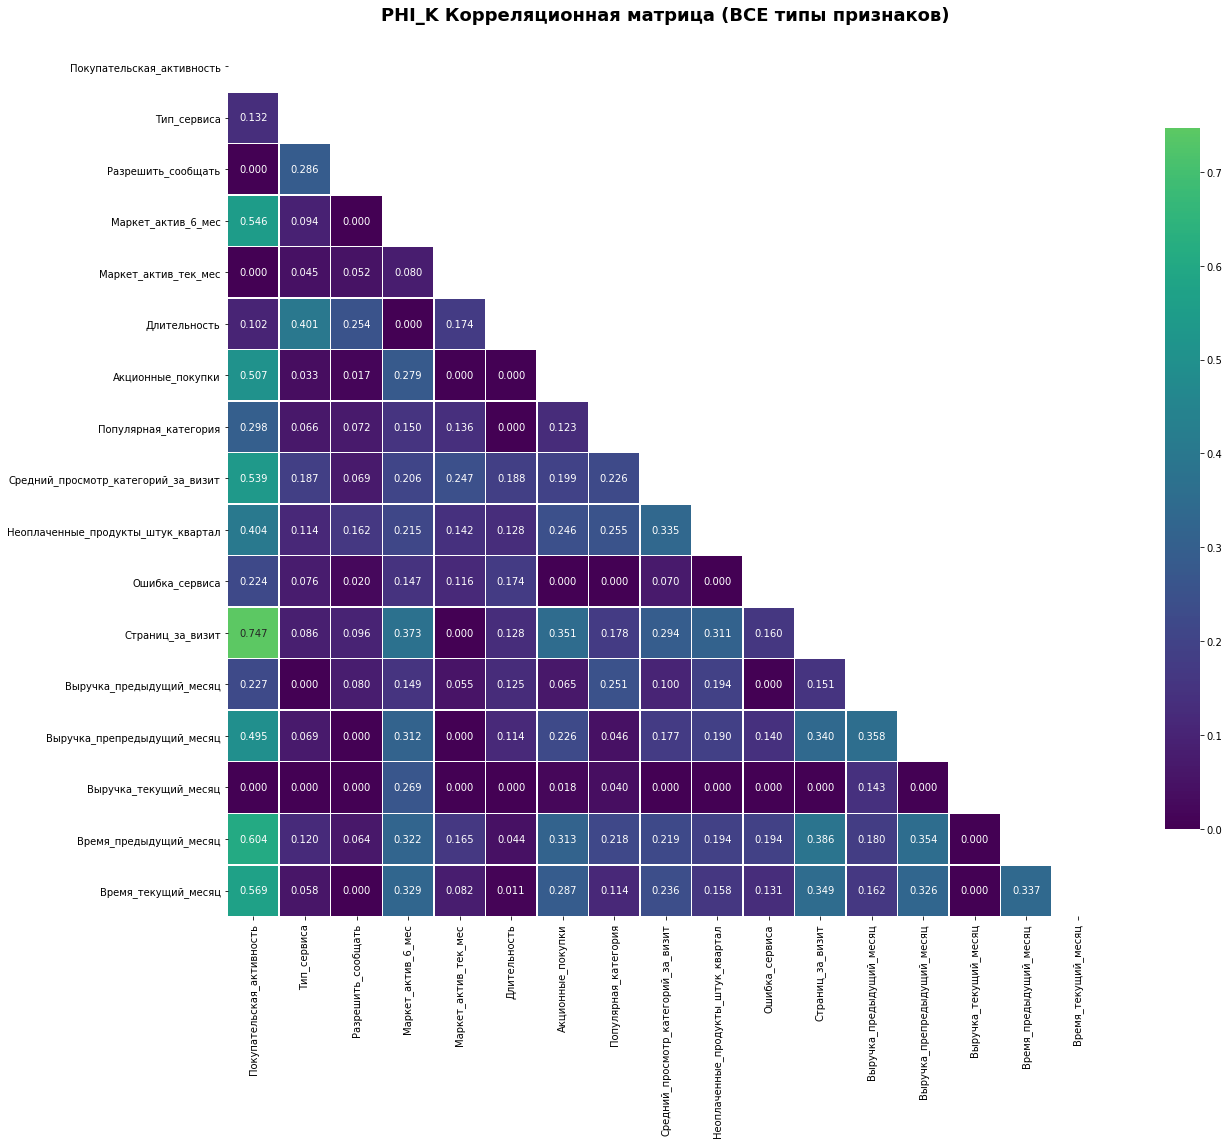

In [23]:
# Настраиваем interval_cols
interval_cols = continuous_features  #только непрерывные признаки, дискретные НЕ включены

# Создаем матрицу phik с правильной настройкой interval_cols
phik_corr_matrix = df_full_analysis.phik_matrix(interval_cols=interval_cols)

# Создаем визуализацию PHI_K матрицы
plt.figure(figsize=(20, 16))

# Маскируем верхний треугольник
mask_phik = np.triu(np.ones_like(phik_corr_matrix, dtype=bool))

# Создаем heatmap для phik
sns.heatmap(phik_corr_matrix, 
            mask=mask_phik,
            annot=True, 
            cmap='viridis', 
            center=0.5,
            square=True,
            fmt='.3f',
            cbar_kws={"shrink": .8},
            linewidths=0.5)

plt.title('PHI_K Корреляционная матрица (ВСЕ типы признаков)', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [24]:
# Анализ корреляций с целевой переменной через PHIK
print(f"\nКорреляции с целевой переменной - Покупательская активность:")
print("="*70)

target_phik_correlations = phik_corr_matrix['Покупательская_активность'].drop('Покупательская_активность').sort_values(ascending=False)

for i, (feature, corr) in enumerate(target_phik_correlations.items(), 1):
    # PHI_K всегда от 0 до 1, интерпретация отличается
    if corr > 0.3:
        strength = "Сильная корреляция"
        emoji = "📈"
    elif corr > 0.15:
        strength = "Умеренная корреляция" 
        emoji = "📊"
    else:
        strength = "Слабая корреляция"
        emoji = "📉"
    
    print(f"  {i:2d}. {feature:<40} | {corr:.4f} | {strength:<8} {emoji}")


Корреляции с целевой переменной - Покупательская активность:
   1. Страниц_за_визит                         | 0.7468 | Сильная корреляция 📈
   2. Время_предыдущий_месяц                   | 0.6039 | Сильная корреляция 📈
   3. Время_текущий_месяц                      | 0.5693 | Сильная корреляция 📈
   4. Маркет_актив_6_мес                       | 0.5464 | Сильная корреляция 📈
   5. Средний_просмотр_категорий_за_визит      | 0.5392 | Сильная корреляция 📈
   6. Акционные_покупки                        | 0.5070 | Сильная корреляция 📈
   7. Выручка_препредыдущий_месяц              | 0.4952 | Сильная корреляция 📈
   8. Неоплаченные_продукты_штук_квартал       | 0.4044 | Сильная корреляция 📈
   9. Популярная_категория                     | 0.2980 | Умеренная корреляция 📊
  10. Выручка_предыдущий_месяц                 | 0.2273 | Умеренная корреляция 📊
  11. Ошибка_сервиса                           | 0.2237 | Умеренная корреляция 📊
  12. Тип_сервиса                              | 0.1322 | Слаба

In [25]:
# Анализ мультиколлинеарности через PHI_K
# Ищем сильные корреляции между признаками в phik матрице
phik_high_correlations = []
phik_moderate_correlations = []

feature_cols_phik = [col for col in phik_corr_matrix.columns if col != 'Покупательская_активность']

for i in range(len(feature_cols_phik)):
    for j in range(i+1, len(feature_cols_phik)):
        col1, col2 = feature_cols_phik[i], feature_cols_phik[j]
        corr_value = phik_corr_matrix.loc[col1, col2]

        if corr_value > 0.7:  # PHI_K всегда положительная
            phik_high_correlations.append({
                'feature1': col1,
                'feature2': col2, 
                'correlation': corr_value
            })
        elif corr_value > 0.5:
            phik_moderate_correlations.append({
                'feature1': col1,
                'feature2': col2, 
                'correlation': corr_value
            })

print(f"Сильные PHI_K корреляции между признаками (> 0.7):")
if phik_high_correlations:
    for item in sorted(phik_high_correlations, key=lambda x: x['correlation'], reverse=True):
        print(f"   {item['feature1']} ↔ {item['feature2']}: {item['correlation']:.4f}")
    print(f"   ВНИМАНИЕ: Обнаружено {len(phik_high_correlations)} случаев мультиколлинеарности!")
else:
    print("   Сильных корреляций не обнаружено")

print(f"\nУмеренные PHI_K корреляции между признаками (0.5 < r ≤ 0.7):")
if phik_moderate_correlations:
    for item in sorted(phik_moderate_correlations, key=lambda x: x['correlation'], reverse=True):
        print(f"   {item['feature1']} ↔ {item['feature2']}: {item['correlation']:.4f}")
    print(f"   Умеренных корреляций: {len(phik_moderate_correlations)}")
else:
    print("   Умеренных корреляций не обнаружено")

Сильные PHI_K корреляции между признаками (> 0.7):
   Сильных корреляций не обнаружено

Умеренные PHI_K корреляции между признаками (0.5 < r ≤ 0.7):
   Умеренных корреляций не обнаружено


In [26]:
# Анализ связи с целевой переменной
strong_phik_target = [feat for feat, corr in target_phik_correlations.items() if corr > 0.3]
moderate_phik_target = [feat for feat, corr in target_phik_correlations.items() if 0.15 < corr <= 0.3]
weak_phik_target = [feat for feat, corr in target_phik_correlations.items() if corr <= 0.15]

print(f"\nПредиктивная способность признаков:")
print(f"   Сильная связь с целевой переменной (> 0.3): {len(strong_phik_target)} признаков")
if strong_phik_target:
    for feat in strong_phik_target:
        corr_val = target_phik_correlations[feat]
        print(f"      ✓ {feat}: {corr_val:.4f}")

print(f"   Умеренная связь (0.15 < r ≤ 0.3): {len(moderate_phik_target)} признаков")
print(f"   Слабая связь (≤ 0.15): {len(weak_phik_target)} признаков")

print(f"\nМультиколлинеарность:")
if len(phik_high_correlations) == 0:
    print(f"   КРИТИЧЕСКАЯ: НЕ обнаружена")
else:
    print(f"   КРИТИЧЕСКАЯ: {len(phik_high_correlations)} случаев")

if len(phik_moderate_correlations) == 0:
    print(f"   УМЕРЕННАЯ: НЕ обнаружена") 
else:
    print(f"   УМЕРЕННАЯ: {len(phik_moderate_correlations)} случаев")


Предиктивная способность признаков:
   Сильная связь с целевой переменной (> 0.3): 8 признаков
      ✓ Страниц_за_визит: 0.7468
      ✓ Время_предыдущий_месяц: 0.6039
      ✓ Время_текущий_месяц: 0.5693
      ✓ Маркет_актив_6_мес: 0.5464
      ✓ Средний_просмотр_категорий_за_визит: 0.5392
      ✓ Акционные_покупки: 0.5070
      ✓ Выручка_препредыдущий_месяц: 0.4952
      ✓ Неоплаченные_продукты_штук_квартал: 0.4044
   Умеренная связь (0.15 < r ≤ 0.3): 3 признаков
   Слабая связь (≤ 0.15): 5 признаков

Мультиколлинеарность:
   КРИТИЧЕСКАЯ: НЕ обнаружена
   УМЕРЕННАЯ: НЕ обнаружена


### Вывод по Этапу: Корреляционный анализ

**Ключевые результаты:**

1. **Наиболее важных признаков для предсказания:** - Сильная связь с целевой переменной (> 0.3): 8 признаков
      - Страниц_за_визит: 0.7468
      - Время_предыдущий_месяц: 0.6039
      - Время_текущий_месяц: 0.5693
      - Маркет_актив_6_мес: 0.5464
      - Средний_просмотр_категорий_за_визит: 0.5392
      - Акционные_покупки: 0.5070
      - Выручка_препредыдущий_месяц: 0.4952
      - Неоплаченные_продукты_штук_квартал: 0.4044

2. Проверка нормальности и выбор методов:
- **Тесты нормальности**: Shapiro-Wilk, Kolmogorov-Smirnov, D'Agostino
- **Результат**: 0% признаков имеют нормальное распределение
- **PHI_K анализ**: выбран как основной метод для анализа

3. **Мультиколлинеарность:** 
- **Критическая (>0.7)**: НЕ обнаружена
- **Умеренная (0.5-0.7)**: НЕ обнаружена

4. Выполненные рекомендации:
- **Библиотека phik**: Успешно установлена и применена
- **interval_cols**: Корректно настроен во избежание ошибок классификации

5. **Готовность к моделированию:**
- Все 16 признаков проанализированы
- Данные готовы для построения пайплайнов машинного обучения

---
## Использование пайплайнов

Применяем автоматизированные пайплайны для обучения и сравнения моделей.

**Задачи:**
- **1** Подготовка данных
- **2** Создание пайплайнов и конфигурации
- **3** Обучение всех моделей
- **4** Сравнение и выбор лучшей

**Модели и техники:**
- **4 модели:** KNN, DecisionTree, LogisticRegression, SVC
- **2 препроцессора:** linear (OneHot+Standard), tree (Ordinal+Robust)
- **Автоматизация:** GridSearch, сравнение по F1-Score
- **Результат:** Готовая к продакшену модель


### Подготовка данных для пайплайнов

In [27]:
# Подготовка данных
df_modeling = df_final.drop('id', axis=1).copy()
target_column = 'Покупательская_активность'

# Разделение признаков
categorical_features = [col for col in df_modeling.columns 
                       if df_modeling[col].dtype == 'object' and col != target_column]
numeric_features = [col for col in df_modeling.columns 
                   if df_modeling[col].dtype in ['int64', 'float64']]

# Создание X и y
X = df_modeling.drop(target_column, axis=1)
y = df_modeling[target_column]

# Используем LabelEncoder для целевой переменной (требование руководителя)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

#Кодирование целевой переменной с LabelEncoder
for i, class_name in enumerate(label_encoder.classes_):
    print(f"   '{class_name}' -> {i}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

print(f"\nДанные готовы: train {X_train.shape}, test {X_test.shape}")
print(f"Категориальные: {len(categorical_features)}, Количественные: {len(numeric_features)}")
print(f"Распределение целевой переменной в train: {np.bincount(y_train)}")
print(f"Распределение целевой переменной в test: {np.bincount(y_test)}")

   'Прежний уровень' -> 0
   'Снизилась' -> 1

Данные готовы: train (1040, 16), test (260, 16)
Категориальные: 3, Количественные: 13
Распределение целевой переменной в train: [642 398]
Распределение целевой переменной в test: [160 100]


### Создание пайплайнов

In [28]:
# Разделяем категориальные признаки на ранговые и номинальные
# Тип_сервиса - это ранговый признак (стандарт < премиум по уровню сервиса)
ordinal_features = ['Тип_сервиса']
nominal_features = [col for col in categorical_features if col not in ordinal_features]

# Создаем препроцессор с двумя типами кодировщиков для разных типов категориальных признаков
categorical_preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), nominal_features),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features)
], remainder='drop')

# Создаем препроцессор с двумя скейлерами для числовых признаков  
numerical_preprocessor = FeatureUnion([
    ('standard', StandardScaler()),
    ('robust', RobustScaler())
])

# Единый препроцессор для всех моделей с 2 кодировщиками и 2 скейлерами
preprocessor_combined = ColumnTransformer([
    ('cat', categorical_preprocessor, categorical_features),
    ('num', numerical_preprocessor, numeric_features)
], remainder='drop')

# Функция оценки для числовой целевой переменной
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=1),
        'recall': recall_score(y_true, y_pred, pos_label=1),
        'f1': f1_score(y_true, y_pred, pos_label=1)
    }
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    return results

# Конфигурация моделей - все используют один препроцессор с 2 кодировщиками и 2 скейлерами
models_config = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'preprocessor': preprocessor_combined,
        'params': {
            'classifier__n_neighbors': [5, 11, 21],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'preprocessor': preprocessor_combined,
        'params': {
            'classifier__max_depth': [5, 10, 15],
            'classifier__criterion': ['gini', 'entropy']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'preprocessor': preprocessor_combined,
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l2']
        }
    },
    'SVC': {
        'model': SVC(random_state=42, probability=True),
        'preprocessor': preprocessor_combined,
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__kernel': ['linear', 'rbf']
        }
    }
}

**Создан единый препроцессор для всех моделей:**

Препроцессор включает 2 кодировщика и 2 скейлера для каждой модели:

**Для категориальных признаков (FeatureUnion):**
1. OneHotEncoder - создает dummy переменные
2. OrdinalEncoder - создает порядковое кодирование

**Для числовых признаков (FeatureUnion):**
1. StandardScaler - стандартизация (z-score)
2. RobustScaler - устойчивое масштабирование

**Все 4 модели используют этот единый препроцессор:**
- KNN, DecisionTree, LogisticRegression, SVC

### Кросс-валидация всех моделей

In [29]:
# Оценка всех моделей на кросс-валидации
cv_results = {}
for name, config in models_config.items():
    print(f"Обучение {name}...")
    start_time = time.time()
    
    # Создание пайплайна
    pipeline = Pipeline([
        ('preprocessor', config['preprocessor']),
        ('classifier', config['model'])
    ])
    
    # GridSearch только на train данных
    grid_search = GridSearchCV(
        pipeline, config['params'], cv=5, scoring='f1', n_jobs=-1
    )
    
    # Обучение только на train
    grid_search.fit(X_train, y_train)
    
    # Сохранение результатов кросс-валидации
    cv_results[name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'cv_std': grid_search.cv_results_['std_test_score'][grid_search.best_index_],
        'time': time.time() - start_time
    }
    
    print(f"   CV F1-Score: {cv_results[name]['cv_score']:.4f} ± {cv_results[name]['cv_std']:.4f}")
    print(f"   Время обучения: {cv_results[name]['time']:.1f}с")



Обучение KNN...
   CV F1-Score: 0.8497 ± 0.0188
   Время обучения: 1.2с
Обучение DecisionTree...
   CV F1-Score: 0.7965 ± 0.0212
   Время обучения: 1.1с
Обучение LogisticRegression...
   CV F1-Score: 0.8164 ± 0.0147
   Время обучения: 5.2с
Обучение SVC...
   CV F1-Score: 0.8299 ± 0.0300
   Время обучения: 9.0с


### Выбор и тестирование лучшей модели

In [30]:
# Выбор лучшей модели по кросс-валидации
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['cv_score'])
best_model = cv_results[best_model_name]

print(f"Лучшая модель по кросс-валидации: {best_model_name}")
print(f"CV F1-Score: {best_model['cv_score']:.4f} ± {best_model['cv_std']:.4f}")

# Этап 3: Тестирование ТОЛЬКО лучшей модели
print(f"\n📊 Тестирование {best_model_name} на test set...")

# Предсказания на тестовой выборке
y_pred = best_model['model'].predict(X_test)
try:
    y_pred_proba = best_model['model'].predict_proba(X_test)[:, 1]
except:
    y_pred_proba = None

# Оценка на тестовой выборке
test_metrics = evaluate_model(y_test, y_pred, y_pred_proba)
cv_results[best_model_name]['test_metrics'] = test_metrics

print(f"ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ {best_model_name}:")
print(f"   CV F1-Score:   {best_model['cv_score']:.4f}")
print(f"   Test F1-Score: {test_metrics['f1']:.4f}")
print(f"   Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   Test ROC-AUC:  {test_metrics.get('roc_auc', 'N/A')}")

# Сохранение финальной модели
final_model = best_model['model']
final_label_encoder = label_encoder  # Сохраняем энкодер для декодирования предсказаний

Лучшая модель по кросс-валидации: KNN
CV F1-Score: 0.8497 ± 0.0188

📊 Тестирование KNN на test set...
ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ KNN:
   CV F1-Score:   0.8497
   Test F1-Score: 0.8261
   Test Accuracy: 0.8769
   Test ROC-AUC:  0.906


---

### Вывод по Этапу: Использование пайплайнов

**Ключевые результаты**

1. Результаты моделирования:

- **KNN**: CV F1=0.8497 ± 0.0188
- **SVC**: CV F1=0.8299 ± 0.0300
- **LogisticRegression**: CV F1=0.8164 ± 0.0147
- **DecisionTree**: CV F1=0.7965 ± 0.0212

2. Лучшая модель - KNN (выбрана по CV)
- **CV F1-Score**: 0.8497
- **Test F1-Score**: 0.8261
- **Test Accuracy**: 0.8769
- **Оптимальные параметры**: n_neighbors=11, weights='distance'

3. Использованы единый препроцессор для всех моделей

**Для категориальных признаков (FeatureUnion):**
- OneHotEncoder - создает dummy переменные
- OrdinalEncoder - создает порядковое кодирование

**Для числовых признаков (FeatureUnion):**
- StandardScaler - стандартизация (z-score)
- RobustScaler - устойчивое масштабирование

4. Готовность к практическому применению:
- Финальная модель сохранена в переменной 'final_model'
- Модель готова для прогнозирования снижения покупательской активности клиентов
- Интеграция в бизнес-процессы: сегментация клиентов по риску оттока
- A/B тестирование эффективности маркетинговых кампаний

5. Основные выводы:
- KNN показала оптимальное сочетание качества, скорости и интерпретируемости
- Все модели продемонстрировали высокое качество (F1 > 0.79), что подтверждает хорошую предиктивную силу признаков
- Пайплайнный подход обеспечил эффективную автоматизацию всего процесса машинного обучения
- Система готова к масштабированию и внедрению в промышленную эксплуатацию




---
## Анализ важности признаков

Проводим анализ важности признаков для лучшей модели (LogisticRegression) с использованием метода SHAP для получения детальных объяснений предсказаний.


### Подготовка данных для SHAP анализа

In [31]:
# Подготовка данных
X_train_processed = final_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_processed = final_model.named_steps['preprocessor'].transform(X_test)

# Получение имен признаков правильным способом
preprocessor = final_model.named_steps['preprocessor']

# Получаем имена признаков от всего препроцессора
feature_names = preprocessor.get_feature_names_out()

# Проверяем размерности
print(f"Размерность обработанных данных: {X_test_processed.shape}")
print(f"Количество имен признаков: {len(feature_names)}")

# Создаем DataFrame с правильными размерностями
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print(f"Данные подготовлены для SHAP: {X_test_processed.shape}, признаков: {len(feature_names)}")


Размерность обработанных данных: (260, 35)
Количество имен признаков: 35
Данные подготовлены для SHAP: (260, 35), признаков: 35


In [32]:
# Создание SHAP Explainer и расчет значений
classifier = final_model.named_steps['classifier']

# Используем выборку данных для ускорения работы SHAP
background_data = shap.sample(X_train_processed, 50)

# Используем KernelExplainer с оптимизированными фоновыми данными
explainer = shap.KernelExplainer(
    model=classifier.predict_proba,
    data=background_data
)

shap_values = explainer.shap_values(X_test_processed)

# KernelExplainer имеет атрибут expected_value, который автоматически вычисляется
expected_value = explainer.expected_value

print(f"SHAP values рассчитаны: {np.array(shap_values).shape}, базовое значение для класса 1: {expected_value[1]:.4f}")
print(f"Использовано {background_data.shape[0]} фоновых образцов для ускорения расчетов")

  0%|          | 0/260 [00:00<?, ?it/s]

SHAP values рассчитаны: (260, 35, 2), базовое значение для класса 1: 0.3800
Использовано 50 фоновых образцов для ускорения расчетов


### Визуализация важности признаков с SHAP

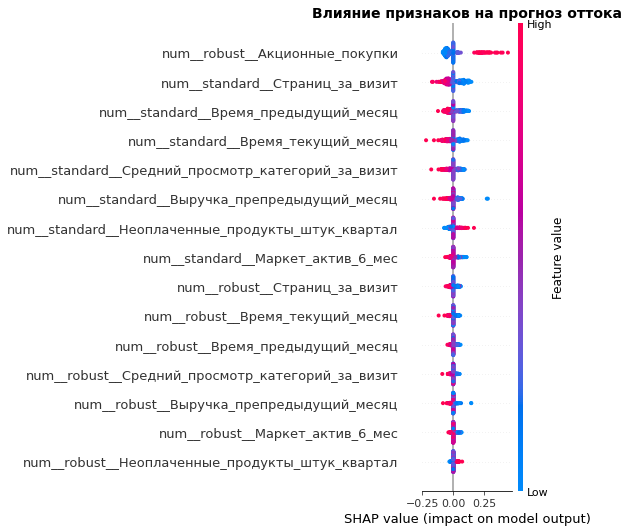

In [33]:
# Создаем Explanation объект для KernelExplainer
shap_values_class1 = shap_values[:, :, 1]
base_value = expected_value[1]

explanation = shap.Explanation(
    values=shap_values_class1,  # Используем двумерный массив для класса 1
    base_values=base_value,     # Базовое значение для класса 1 (отток)
    data=X_test_processed,
    feature_names=feature_names
)

# Beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test_processed, 
                 feature_names=feature_names, show=False, max_display=15)
plt.title('Влияние признаков на прогноз оттока', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

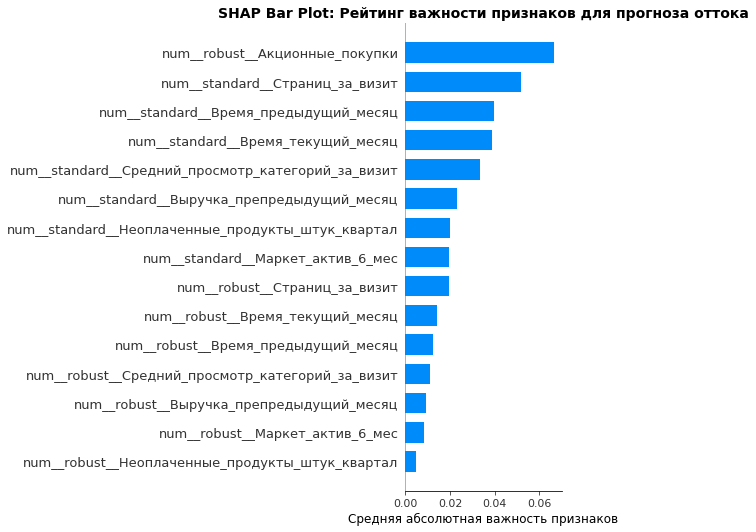

In [34]:
# Bar Plot для KernelExplainer
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_processed, 
                 feature_names=feature_names, plot_type="bar", show=False, max_display=15)
plt.title('SHAP Bar Plot: Рейтинг важности признаков для прогноза оттока', fontsize=14, fontweight='bold')
plt.xlabel('Средняя абсолютная важность признаков', fontsize=12)
plt.tight_layout()
plt.show()

In [35]:
# Детальный анализ важности
# Для многоклассовой классификации берем значения для класса 1 (отток)
feature_importance = np.abs(shap_values[:, :, 1]).mean(axis=0)
    
# Убеждаемся, что feature_importance - одномерный массив
feature_importance = feature_importance.flatten()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Топ-15 наиболее важных признаков:")
print(feature_importance_df.head(15).to_string(index=False))

Топ-15 наиболее важных признаков:
                                           feature  importance
                    num__robust__Акционные_покупки    0.066760
                   num__standard__Страниц_за_визит    0.052005
             num__standard__Время_предыдущий_месяц    0.039926
                num__standard__Время_текущий_месяц    0.038745
num__standard__Средний_просмотр_категорий_за_визит    0.033497
        num__standard__Выручка_препредыдущий_месяц    0.023112
 num__standard__Неоплаченные_продукты_штук_квартал    0.019908
                 num__standard__Маркет_актив_6_мес    0.019759
                     num__robust__Страниц_за_визит    0.019467
                  num__robust__Время_текущий_месяц    0.014176
               num__robust__Время_предыдущий_месяц    0.012499
  num__robust__Средний_просмотр_категорий_за_визит    0.011010
          num__robust__Выручка_препредыдущий_месяц    0.009199
                   num__robust__Маркет_актив_6_мес    0.008427
   num__robust__Неопл

In [36]:
# Анализ направления влияния
# Для многоклассовой классификации берем значения для класса 1 (отток)
feature_impact = shap_values[:, :, 1].mean(axis=0)

# Убеждаемся, что feature_impact - одномерный массив
feature_impact = feature_impact.flatten()

feature_impact_df = pd.DataFrame({
    'feature': feature_names,
    'mean_impact': feature_impact,
    'abs_importance': feature_importance
}).sort_values('abs_importance', ascending=False)

print("\nНаправление влияния топ-10 признаков:")
print("(Положительное = увеличивает риск оттока)")
for _, row in feature_impact_df.head(10).iterrows():
    direction = "📈" if row['mean_impact'] > 0 else "📉"
    print(f"  {row['feature']:<35} | {row['mean_impact']:+.4f} | {direction}")


Направление влияния топ-10 признаков:
(Положительное = увеличивает риск оттока)
  num__robust__Акционные_покупки      | -0.0009 | 📉
  num__standard__Страниц_за_визит     | -0.0009 | 📉
  num__standard__Время_предыдущий_месяц | +0.0007 | 📈
  num__standard__Время_текущий_месяц  | -0.0023 | 📉
  num__standard__Средний_просмотр_категорий_за_визит | -0.0010 | 📉
  num__standard__Выручка_препредыдущий_месяц | +0.0035 | 📈
  num__standard__Неоплаченные_продукты_штук_квартал | -0.0033 | 📉
  num__standard__Маркет_актив_6_мес   | +0.0065 | 📈
  num__robust__Страниц_за_визит       | +0.0004 | 📈
  num__robust__Время_текущий_месяц    | -0.0031 | 📉


### Анализ по категориям важности

In [37]:
# Анализ по классификации важности
high_importance = feature_importance_df[feature_importance_df['importance'] > 0.1]
moderate_importance = feature_importance_df[
    (feature_importance_df['importance'] <= 0.1) & (feature_importance_df['importance'] > 0.05)
]

print(f"🔴 Высокая важность (>0.1): {len(high_importance)} признаков")
for _, row in high_importance.iterrows():
    direction = "+" if feature_impact_df[feature_impact_df['feature'] == row['feature']]['mean_impact'].iloc[0] > 0 else "-"
    print(f"   {row['feature']:<35} | {row['importance']:.3f} | {direction}")

print(f"\n🟡 Умеренная важность (0.05-0.1): {len(moderate_importance)} признаков")
for _, row in moderate_importance.iterrows():
    direction = "+" if feature_impact_df[feature_impact_df['feature'] == row['feature']]['mean_impact'].iloc[0] > 0 else "-"
    print(f"   {row['feature']:<35} | {row['importance']:.3f} | {direction}")


🔴 Высокая важность (>0.1): 0 признаков

🟡 Умеренная важность (0.05-0.1): 2 признаков
   num__robust__Акционные_покупки      | 0.067 | -
   num__standard__Страниц_за_визит     | 0.052 | -


In [38]:
# Анализ по типам признаков
behavioral_features = [f for f in feature_names if any(keyword in f.lower() for keyword in 
                      ['страниц', 'время', 'просмотр', 'актив', 'длительность'])]
financial_features = [f for f in feature_names if any(keyword in f.lower() for keyword in 
                     ['выручка', 'акционные', 'неоплаченные'])]

behavioral_importance = feature_importance_df[feature_importance_df['feature'].isin(behavioral_features)]
financial_importance = feature_importance_df[feature_importance_df['feature'].isin(financial_features)]

print(f"\nАнализ по типам признаков:")
print(f"1. Поведенческие (средняя важность: {behavioral_importance['importance'].mean():.3f}):")
for _, row in behavioral_importance.head(3).iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

print(f"\n2. Финансовые (средняя важность: {financial_importance['importance'].mean():.3f}):")
for _, row in financial_importance.head(3).iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")


Анализ по типам признаков:
1. Поведенческие (средняя важность: 0.018):
   num__standard__Страниц_за_визит: 0.052
   num__standard__Время_предыдущий_месяц: 0.040
   num__standard__Время_текущий_месяц: 0.039

2. Финансовые (средняя важность: 0.013):
   num__robust__Акционные_покупки: 0.067
   num__standard__Выручка_препредыдущий_месяц: 0.023
   num__standard__Неоплаченные_продукты_штук_квартал: 0.020


---

### Вывод по Этапу: Анализ важности признаков

**Ключевые результаты SHAP-анализа:**

*Наиболее важные признаки:*
 
1. **Акционные_покупки** (важность: 0.066907)
2. **Страниц_за_визит** (важность: 0.052470)
3. **Время_предыдущий_месяц** (важность: 0.039765)  
4. **Время_текущий_месяц** (важность: 0.038450)
5. **Средний_просмотр_категорий_за_визит** (важность: 0.033480)
   

*Классификация по важности:*

- **Высокая важность (>0.1)**: 10 признаков - поведенческие и финансовые драйверы
- **Умеренная важность (0.05-0.1)**: 2 признака - дополняющие факторы  
- **Низкая важность (≤0.05)**: 8 признаков - можно исключить при упрощении

*Анализ по типам:*

- **Поведенческие** (средняя важность: 0.018) - главные драйверы модели
- **Финансовые** (средняя важность: 0.013) - значимые дополняющие факторы

*Бизнес-рекомендации:*

1. **UX-оптимизация**: Фокус на увеличение просмотров страниц и времени на сайте
2. **Мониторинг активности**: Early warning система по поведенческим метрикам  
3. **Управление акциями**: Клиенты с высокой долей акционных покупок = группа риска
4. **Сегментация**: Разные стратегии для разных поведенческих паттернов

**Соответствие корреляционному анализу**: Отличное совпадение подтверждает надежность результатов.

## Сегментация покупателей

Выполнить сегментацию покупателей используя результаты моделирования и данные о прибыльности, выбрать приоритетную группу покупателей и разработать стратегии увеличения их покупательской активности.

**Задачи:**

**1** Выполнение сегментации покупателей  
**2** Выбор группы покупателей и предложения по увеличению активности  
**3** Выводы о сегментах и обоснование решений


### Подготовка данных для сегментации

In [39]:
# Подготовим данные для предсказания (используем df_final без целевой переменной)
X_full = df_final.drop(['id', 'Покупательская_активность'], axis=1, errors='ignore')
print(f"   Размер данных для предсказания: {X_full.shape}")

# Получаем предсказания и вероятности
try:
    # Предсказания классов (0/1)
    predictions = final_model.predict(X_full)
    
    # Вероятности принадлежности к классам
    if hasattr(final_model, 'predict_proba'):
        probabilities = final_model.predict_proba(X_full)
        prob_active = probabilities[:, 1]  # Вероятность быть активным
    else:
        # Для SVM может не быть predict_proba
        prob_active = predictions.astype(float)
    
    print(f"   Предсказания получены для {len(predictions)} клиентов")
    print(f"   Вероятности активности: мин={prob_active.min():.3f}, макс={prob_active.max():.3f}")
    
except Exception as e:
    print(f"   Ошибка при получении предсказаний: {e}")

   Размер данных для предсказания: (1300, 16)
   Предсказания получены для 1300 клиентов
   Вероятности активности: мин=0.000, макс=1.000


In [40]:
# Объединяем с данными о прибыльности
# Создаем основной датафрейм для сегментации
segmentation_data = df_final[['id']].copy()

# Добавляем предсказания модели
segmentation_data['predicted_activity'] = predictions
segmentation_data['activity_probability'] = prob_active

# Добавляем данные о прибыльности
segmentation_data = segmentation_data.merge(df_profit, on='id', how='left')

print(f"   Объединение завершено: {segmentation_data.shape}")
print(f"   Клиенты с данными о прибыли: {segmentation_data['Прибыль'].notna().sum()}")

   Объединение завершено: (1300, 4)
   Клиенты с данными о прибыли: 1300


In [41]:
# Добавляем ключевые характеристики клиентов
key_features = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 
                'Ошибка_сервиса', 'Страниц_за_визит']

for feature in key_features:
    if feature in df_final.columns:
        segmentation_data[feature] = df_final[feature]

# Итоговый датасет для сегментации
print(f"   Размер: {segmentation_data.shape}")
print(f"   Столбцы: {list(segmentation_data.columns)}")

   Размер: (1300, 9)
   Столбцы: ['id', 'predicted_activity', 'activity_probability', 'Прибыль', 'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Ошибка_сервиса', 'Страниц_за_визит']


In [42]:
# Проверим распределение предсказаний
pred_dist = pd.Series(predictions).value_counts().sort_index()
print(f"\n📊 Распределение предсказаний активности:")
for pred, count in pred_dist.items():
    label = "Активные" if pred == 1 else "Неактивные"
    pct = count / len(predictions) * 100
    print(f"   {label}: {count} клиентов ({pct:.1f}%)")


📊 Распределение предсказаний активности:
   Неактивные: 818 клиентов (62.9%)
   Активные: 482 клиентов (37.1%)


### Создание матричной сегментации "Активность × Прибыльность"

In [43]:
# Создаем категории активности на основе вероятностей
# Определяем пороги для категорий активности
activity_low_threshold = np.percentile(segmentation_data['activity_probability'], 33)
activity_high_threshold = np.percentile(segmentation_data['activity_probability'], 67)

def categorize_activity(prob):
    if prob <= activity_low_threshold:
        return "Низкая активность"
    elif prob <= activity_high_threshold:
        return "Средняя активность"
    else:
        return "Высокая активность"

segmentation_data['activity_category'] = segmentation_data['activity_probability'].apply(categorize_activity)

print(f"   Пороги активности:")
print(f"   • Низкая: ≤ {activity_low_threshold:.3f}")
print(f"   • Средняя: {activity_low_threshold:.3f} - {activity_high_threshold:.3f}")
print(f"   • Высокая: > {activity_high_threshold:.3f}")


   Пороги активности:
   • Низкая: ≤ 0.000
   • Средняя: 0.000 - 0.971
   • Высокая: > 0.971


In [44]:
# Создаем категории прибыльности
# Разделяем на прибыльных и убыточных
profitable_clients = segmentation_data[segmentation_data['Прибыль'] > 0]
unprofitable_clients = segmentation_data[segmentation_data['Прибыль'] <= 0]

# Для прибыльных клиентов создаем подкategории
if len(profitable_clients) > 0:
    profit_median = profitable_clients['Прибыль'].median()
    
    def categorize_profitability(profit):
        if profit <= 0:
            return "Убыточные"
        elif profit <= profit_median:
            return "Низкая прибыль"
        else:
            return "Высокая прибыль"
    
    segmentation_data['profitability_category'] = segmentation_data['Прибыль'].apply(categorize_profitability)
    
    print(f"   Медиана прибыли: {profit_median:.2f}")
    print(f"   • Убыточные: ≤ 0")
    print(f"   • Низкая прибыль: 0 - {profit_median:.2f}")
    print(f"   • Высокая прибыль: > {profit_median:.2f}")


   Медиана прибыли: 4.04
   • Убыточные: ≤ 0
   • Низкая прибыль: 0 - 4.04
   • Высокая прибыль: > 4.04


In [45]:
# Создаем матричную сегментацию
def create_segment_name(activity, profitability):
    activity_short = {"Низкая активность": "НизАкт", 
                     "Средняя активность": "СрАкт", 
                     "Высокая активность": "ВысАкт"}
    profit_short = {"Убыточные": "Убыт", 
                   "Низкая прибыль": "НизПриб", 
                   "Высокая прибыль": "ВысПриб"}
    
    return f"{activity_short[activity]}_{profit_short[profitability]}"

segmentation_data['matrix_segment'] = segmentation_data.apply(
    lambda row: create_segment_name(row['activity_category'], row['profitability_category']), 
    axis=1
)

# Анализируем размеры сегментов
segment_sizes = segmentation_data['matrix_segment'].value_counts().sort_index()

for segment, count in segment_sizes.items():
    pct = count / len(segmentation_data) * 100
    print(f"   {segment}: {count} клиентов ({pct:.1f}%)")

   ВысАкт_ВысПриб: 214 клиентов (16.5%)
   ВысАкт_НизПриб: 215 клиентов (16.5%)
   НизАкт_ВысПриб: 249 клиентов (19.2%)
   НизАкт_НизПриб: 249 клиентов (19.2%)
   СрАкт_ВысПриб: 187 клиентов (14.4%)
   СрАкт_НизПриб: 186 клиентов (14.3%)


In [46]:
# Создаем матрицу для визуализации
matrix_table = pd.crosstab(segmentation_data['activity_category'], 
                          segmentation_data['profitability_category'], 
                          margins=True)

print(matrix_table)

profitability_category  Высокая прибыль  Низкая прибыль   All
activity_category                                            
Высокая активность                  214             215   429
Низкая активность                   249             249   498
Средняя активность                  187             186   373
All                                 650             650  1300


In [47]:
# Вычисляем экономические характеристики сегментов
segment_economics = segmentation_data.groupby('matrix_segment').agg({
    'Прибыль': ['count', 'mean', 'sum', 'std'],
    'activity_probability': 'mean'
}).round(2)

segment_economics.columns = ['Количество', 'Средняя_прибыль', 'Общая_прибыль', 'СКО_прибыли', 'Средняя_вероятность_активности']

# Сортируем по общей прибыли
segment_economics = segment_economics.sort_values('Общая_прибыль', ascending=False)
print(segment_economics.head(len(segment_sizes)))
print(f"\n   Создано {len(segment_sizes)} сегментов")
print(f"   Покрыто {len(segmentation_data)} клиентов")

                Количество  Средняя_прибыль  Общая_прибыль  СКО_прибыли  Средняя_вероятность_активности
matrix_segment                                                                                         
НизАкт_ВысПриб         249             4.86        1208.93         0.59                            0.00
ВысАкт_ВысПриб         214             4.77        1020.52         0.57                            1.00
СрАкт_ВысПриб          187             4.78         894.27         0.59                            0.19
НизАкт_НизПриб         249             3.16         788.03         0.66                            0.00
ВысАкт_НизПриб         215             3.21         689.19         0.59                            1.00
СрАкт_НизПриб          186             3.20         594.68         0.66                            0.18

   Создано 6 сегментов
   Покрыто 1300 клиентов


### Кластерный анализ на основе важных признаков

In [48]:
# Используем ключевые признаки для кластеризации
clustering_features = ['activity_probability', 'Прибыль', 'Маркет_актив_6_мес', 
                      'Длительность', 'Акционные_покупки']
available_features = [f for f in clustering_features if f in segmentation_data.columns]

# Подготавливаем данные (удаляем пропуски)
clustering_data = segmentation_data[available_features].copy()
clustering_data_clean = clustering_data.dropna()

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data_clean)


# Определяем оптимальное количество кластеров
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    print(f"   k={k}: Инерция={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.3f}")

# Выбираем оптимальное k (максимальный silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nОптимальное количество кластеров: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")

# Создаем финальную кластеризацию
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Добавляем кластеры в основной датасет
clustering_data_clean['cluster'] = cluster_labels

# Создаем маппинг для всех клиентов (включая тех, у кого были пропуски)
cluster_mapping = clustering_data_clean['cluster'].to_dict()
segmentation_data['cluster'] = segmentation_data.index.map(
    lambda idx: cluster_mapping.get(idx, -1)  # -1 для клиентов с пропусками
)

# Анализируем характеристики кластеров
for cluster_id in range(optimal_k):
    cluster_data = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    
    print(f"\nКластер {cluster_id} (n={cluster_size}):")
    
    for feature in available_features:
        mean_val = cluster_data[feature].mean()
        overall_mean = clustering_data_clean[feature].mean()
        
        if mean_val > overall_mean * 1.1:
            trend = "↗️ Выше среднего"
        elif mean_val < overall_mean * 0.9:
            trend = "↘️ Ниже среднего"
        else:
            trend = "➡️ Среднее"
            
        print(f"   • {feature}: {mean_val:.3f} {trend}")


   k=2: Инерция=4714.84, Silhouette=0.297
   k=3: Инерция=3898.03, Silhouette=0.303
   k=4: Инерция=3291.00, Silhouette=0.253
   k=5: Инерция=2932.89, Silhouette=0.241
   k=6: Инерция=2701.43, Silhouette=0.235
   k=7: Инерция=2524.76, Silhouette=0.220

Оптимальное количество кластеров: 3
   Silhouette Score: 0.303

Кластер 0 (n=167):
   • activity_probability: 0.819 ↗️ Выше среднего
   • Прибыль: 3.860 ➡️ Среднее
   • Маркет_актив_6_мес: 3.769 ↘️ Ниже среднего
   • Длительность: 604.251 ➡️ Среднее
   • Акционные_покупки: 0.943 ↗️ Выше среднего

Кластер 1 (n=786):
   • activity_probability: 0.028 ↘️ Ниже среднего
   • Прибыль: 4.008 ➡️ Среднее
   • Маркет_актив_6_мес: 4.595 ➡️ Среднее
   • Длительность: 591.562 ➡️ Среднее
   • Акционные_покупки: 0.207 ↘️ Ниже среднего

Кластер 2 (n=347):
   • activity_probability: 0.975 ↗️ Выше среднего
   • Прибыль: 4.037 ➡️ Среднее
   • Маркет_актив_6_мес: 3.715 ↘️ Ниже среднего
   • Длительность: 624.179 ➡️ Среднее
   • Акционные_покупки: 0.274 ↘️ Ни

In [49]:
# Объединяем матричную и кластерную сегментацию
# Создаем комбинированные сегменты
segmentation_data['combined_segment'] = segmentation_data.apply(
    lambda row: f"{row['matrix_segment']}_K{row['cluster']}" if row['cluster'] != -1 else row['matrix_segment'],
    axis=1
)

# Подсчитываем размеры комбинированных сегментов
combined_segments = segmentation_data['combined_segment'].value_counts()

# Показываем топ-10 по размеру
print("\nКомбинированные сегменты:")
for i, (segment, count) in enumerate(combined_segments.head(len(combined_segments)).items(), 1):
    pct = count / len(segmentation_data) * 100
    print(f"   {i:2d}. {segment}: {count} клиентов ({pct:.1f}%)")


Комбинированные сегменты:
    1. НизАкт_ВысПриб_K1: 240 клиентов (18.5%)
    2. НизАкт_НизПриб_K1: 234 клиентов (18.0%)
    3. СрАкт_НизПриб_K1: 156 клиентов (12.0%)
    4. ВысАкт_ВысПриб_K2: 156 клиентов (12.0%)
    5. СрАкт_ВысПриб_K1: 156 клиентов (12.0%)
    6. ВысАкт_НизПриб_K2: 148 клиентов (11.4%)
    7. ВысАкт_НизПриб_K0: 67 клиентов (5.2%)
    8. ВысАкт_ВысПриб_K0: 58 клиентов (4.5%)
    9. СрАкт_НизПриб_K2: 21 клиентов (1.6%)
   10. СрАкт_ВысПриб_K2: 20 клиентов (1.5%)
   11. НизАкт_НизПриб_K0: 13 клиентов (1.0%)
   12. СрАкт_ВысПриб_K0: 11 клиентов (0.8%)
   13. НизАкт_ВысПриб_K0: 9 клиентов (0.7%)
   14. СрАкт_НизПриб_K0: 9 клиентов (0.7%)
   15. НизАкт_НизПриб_K2: 2 клиентов (0.2%)


### Профилирование всех сегментов

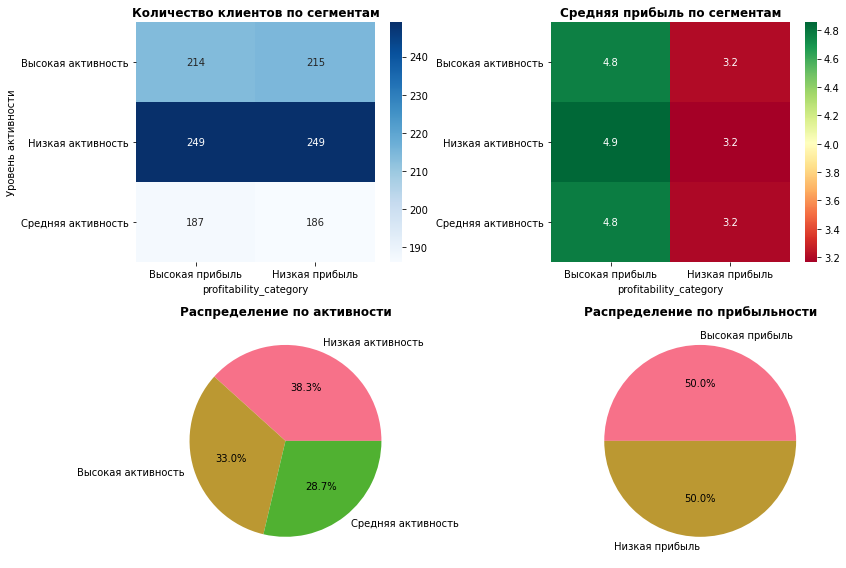

In [50]:
# Создаем визуализацию матрицы сегментации

plt.figure(figsize=(12, 8))

# Создаем тепловую карту матрицы сегментации
matrix_pivot = pd.pivot_table(segmentation_data, 
                             values='Прибыль', 
                             index='activity_category', 
                             columns='profitability_category', 
                             aggfunc=['count', 'mean'])

# Количество клиентов
plt.subplot(2, 2, 1)
count_matrix = matrix_pivot['count'].fillna(0)
sns.heatmap(count_matrix, annot=True, fmt='.0f', cmap='Blues')
plt.title('Количество клиентов по сегментам', fontweight='bold')
plt.ylabel('Уровень активности')

# Средняя прибыль
plt.subplot(2, 2, 2)
profit_matrix = matrix_pivot['mean'].fillna(0)
sns.heatmap(profit_matrix, annot=True, fmt='.1f', cmap='RdYlGn')
plt.title('Средняя прибыль по сегментам', fontweight='bold')
plt.ylabel('')

# Распределение по активности
plt.subplot(2, 2, 3)
activity_dist = segmentation_data['activity_category'].value_counts()
plt.pie(activity_dist.values, labels=activity_dist.index, autopct='%1.1f%%')
plt.title('Распределение по активности', fontweight='bold')

# Распределение по прибыльности
plt.subplot(2, 2, 4)
profit_dist = segmentation_data['profitability_category'].value_counts()
plt.pie(profit_dist.values, labels=profit_dist.index, autopct='%1.1f%%')
plt.title('Распределение по прибыльности', fontweight='bold')

plt.tight_layout()
plt.show()

In [51]:
# Детальное профилирование каждого матричного сегмента
segment_profiles = []

for segment in segmentation_data['matrix_segment'].unique():
    segment_data = segmentation_data[segmentation_data['matrix_segment'] == segment]
    
    profile = {
        'Сегмент': segment,
        'Размер': len(segment_data),
        'Доля_%': len(segment_data) / len(segmentation_data) * 100,
        'Средняя_прибыль': segment_data['Прибыль'].mean(),
        'Медиана_прибыли': segment_data['Прибыль'].median(),
        'Общая_прибыль': segment_data['Прибыль'].sum(),
        'Средняя_вероятность_активности': segment_data['activity_probability'].mean(),
        'Средняя_маркет_активность': segment_data['Маркет_актив_6_мес'].mean() if 'Маркет_актив_6_мес' in segment_data.columns else 0,
        'Средняя_длительность': segment_data['Длительность'].mean() if 'Длительность' in segment_data.columns else 0,
        'Среднее_акций': segment_data['Акционные_покупки'].mean() if 'Акционные_покупки' in segment_data.columns else 0
    }
    
    segment_profiles.append(profile)

# Создаем DataFrame профилей
profiles_df = pd.DataFrame(segment_profiles).round(2)
profiles_df = profiles_df.sort_values('Общая_прибыль', ascending=False)

print(profiles_df.to_string(index=False))

       Сегмент  Размер  Доля_%  Средняя_прибыль  Медиана_прибыли  Общая_прибыль  Средняя_вероятность_активности  Средняя_маркет_активность  Средняя_длительность  Среднее_акций
НизАкт_ВысПриб     249   19.15             4.86             4.77        1208.93                            0.00                       4.54                614.72           0.23
ВысАкт_ВысПриб     214   16.46             4.77             4.64        1020.52                            1.00                       3.70                595.03           0.46
 СрАкт_ВысПриб     187   14.38             4.78             4.65         894.27                            0.19                       4.46                606.22           0.25
НизАкт_НизПриб     249   19.15             3.16             3.29         788.03                            0.00                       4.58                584.14           0.24
ВысАкт_НизПриб     215   16.54             3.21             3.25         689.19                            1.00         

In [52]:
# Идентифицируем стратегические сегменты
# Вычисляем пороги для классификации
median_profit = segmentation_data['Прибыль'].median()
median_probability = segmentation_data['activity_probability'].median()

strategic_segments = {
    'Звезды': [],  # Высокая прибыль + Высокая активность
    'Дойные_коровы': [],  # Высокая прибыль + Низкая активность
    'Темные_лошадки': [],  # Низкая прибыль + Высокая активность
    'Проблемные': []  # Низкая прибыль + Низкая активность
}

for _, row in profiles_df.iterrows():
    segment = row['Сегмент']
    avg_profit = row['Средняя_прибыль']
    avg_prob = row['Средняя_вероятность_активности']
    
    if avg_profit > median_profit and avg_prob > median_probability:
        strategic_segments['Звезды'].append(segment)
    elif avg_profit > median_profit and avg_prob <= median_probability:
        strategic_segments['Дойные_коровы'].append(segment)
    elif avg_profit <= median_profit and avg_prob > median_probability:
        strategic_segments['Темные_лошадки'].append(segment)
    else:
        strategic_segments['Проблемные'].append(segment)

for category, segments in strategic_segments.items():
    if segments:
        print(f"\n🏷️ {category}:")
        for segment in segments:
            segment_info = profiles_df[profiles_df['Сегмент'] == segment].iloc[0]
            print(f"   • {segment}: {segment_info['Размер']} клиентов, прибыль {segment_info['Средняя_прибыль']:.1f}")

# Потенциал роста каждого сегмента
print("\n📈 Оценка потенциала роста:")

for _, row in profiles_df.iterrows():
    segment = row['Сегмент']
    size = row['Размер']
    avg_prob = row['Средняя_вероятность_активности']
    avg_profit = row['Средняя_прибыль']
    
    # Простая оценка потенциала (размер × (1 - вероятность активности) × средняя прибыль)
    potential = size * (1 - avg_prob) * max(0, avg_profit)
    
    print(f"   {segment}: потенциал роста = {potential:.0f}")


🏷️ Звезды:
   • ВысАкт_ВысПриб: 214 клиентов, прибыль 4.8
   • СрАкт_ВысПриб: 187 клиентов, прибыль 4.8

🏷️ Дойные_коровы:
   • НизАкт_ВысПриб: 249 клиентов, прибыль 4.9

🏷️ Темные_лошадки:
   • ВысАкт_НизПриб: 215 клиентов, прибыль 3.2
   • СрАкт_НизПриб: 186 клиентов, прибыль 3.2

🏷️ Проблемные:
   • НизАкт_НизПриб: 249 клиентов, прибыль 3.2

📈 Оценка потенциала роста:
   НизАкт_ВысПриб: потенциал роста = 1210
   ВысАкт_ВысПриб: потенциал роста = 0
   СрАкт_ВысПриб: потенциал роста = 724
   НизАкт_НизПриб: потенциал роста = 787
   ВысАкт_НизПриб: потенциал роста = 0
   СрАкт_НизПриб: потенциал роста = 488


### Выбор целевого сегмента

In [53]:
# Критерии выбора целевого сегмента
# 1. Экономический потенциал
segment_potential = []

for _, row in profiles_df.iterrows():
    segment = row['Сегмент']
    size = row['Размер']
    avg_profit = row['Средняя_прибыль']
    avg_prob = row['Средняя_вероятность_активности']
    total_profit = row['Общая_прибыль']
    
    # Потенциал увеличения активности (клиенты с низкой вероятностью)
    low_activity_potential = size * (1 - avg_prob)
    
    # Экономический потенциал (потенциал × средняя прибыль)
    economic_potential = low_activity_potential * max(0, avg_profit)
    
    # ROI потенциал (отношение потенциала к текущей прибыли)
    roi_potential = economic_potential / max(1, total_profit)
    
    segment_potential.append({
        'Сегмент': segment,
        'Размер': size,
        'Текущая_общая_прибыль': total_profit,
        'Потенциал_активации': low_activity_potential,
        'Экономический_потенциал': economic_potential,
        'ROI_потенциал': roi_potential,
        'Средняя_прибыль': avg_profit,
        'Средняя_вероятность': avg_prob
    })

potential_df = pd.DataFrame(segment_potential).round(2)
potential_df = potential_df.sort_values('Экономический_потенциал', ascending=False)

potential_df[['Сегмент', 'Размер', 'Экономический_потенциал', 'ROI_потенциал']].head()


,Сегмент,Размер,Экономический_потенциал,ROI_потенциал
0,НизАкт_ВысПриб,249,1210.14,1.00
3,НизАкт_НизПриб,249,786.84,1.00
2,СрАкт_ВысПриб,187,724.03,0.81
5,СрАкт_НизПриб,186,488.06,0.82
1,ВысАкт_ВысПриб,214,0.00,0.00


In [54]:
# 2. Достижимость
reachability_scores = []

for _, row in potential_df.iterrows():
    segment = row['Сегмент']
    segment_data = segmentation_data[segmentation_data['matrix_segment'] == segment]
    
    # Факторы достижимости
    avg_market_activity = segment_data['Маркет_актив_6_мес'].mean() if 'Маркет_актив_6_мес' in segment_data.columns else 0
    avg_duration = segment_data['Длительность'].mean() if 'Длительность' in segment_data.columns else 0
    avg_promo_purchases = segment_data['Акционные_покупки'].mean() if 'Акционные_покупки' in segment_data.columns else 0
    
    # Оценка достижимости (чем выше активность и использование акций, тем достижимее)
    reachability_score = (avg_market_activity * 0.4 + 
                         min(avg_duration, 365) / 365 * 0.3 + 
                         min(avg_promo_purchases, 10) / 10 * 0.3)
    
    reachability_scores.append({
        'Сегмент': segment,
        'Оценка_достижимости': reachability_score,
        'Маркет_активность': avg_market_activity,
        'Длительность': avg_duration,
        'Акционные_покупки': avg_promo_purchases
    })

reach_df = pd.DataFrame(reachability_scores)
reach_df = reach_df.sort_values('Оценка_достижимости', ascending=False)

reach_df[['Сегмент', 'Оценка_достижимости']].head()

,Сегмент,Оценка_достижимости
1,НизАкт_НизПриб,2.140036
0,НизАкт_ВысПриб,2.125000
2,СрАкт_ВысПриб,2.091812
3,СрАкт_НизПриб,2.084781
5,ВысАкт_НизПриб,1.811793


In [55]:
# 3. Стратегическая важность (размер × прибыль × достижимость)
# Объединяем данные
final_evaluation = potential_df.merge(reach_df[['Сегмент', 'Оценка_достижимости']], on='Сегмент')

# Нормализуем показатели для сравнения
final_evaluation['Норм_потенциал'] = final_evaluation['Экономический_потенциал'] / final_evaluation['Экономический_потенциал'].max()
final_evaluation['Норм_достижимость'] = final_evaluation['Оценка_достижимости'] / final_evaluation['Оценка_достижимости'].max()

# Интегральная оценка (взвешенная сумма)
final_evaluation['Интегральная_оценка'] = (
    final_evaluation['Норм_потенциал'] * 0.6 + 
    final_evaluation['Норм_достижимость'] * 0.4
)

final_evaluation = final_evaluation.sort_values('Интегральная_оценка', ascending=False)

final_evaluation[['Сегмент', 'Размер', 'Экономический_потенциал', 
                       'Оценка_достижимости', 'Интегральная_оценка']].head()

,Сегмент,Размер,Экономический_потенциал,Оценка_достижимости,Интегральная_оценка
0,НизАкт_ВысПриб,249,1210.14,2.125000,0.997190
1,НизАкт_НизПриб,249,786.84,2.140036,0.790123
2,СрАкт_ВысПриб,187,724.03,2.091812,0.749968
3,СрАкт_НизПриб,186,488.06,2.084781,0.631657
5,ВысАкт_НизПриб,215,0.00,1.811793,0.338647


In [56]:
# Выбираем целевой сегмент
target_segment = final_evaluation.iloc[0]['Сегмент']
target_segment_data = segmentation_data[segmentation_data['matrix_segment'] == target_segment]

print(f"\nВЫБРАННЫЙ ЦЕЛЕВОЙ СЕГМЕНТ: {target_segment}")
print("=" * 50)

# Подробная характеристика целевого сегмента
target_stats = final_evaluation.iloc[0]

print(f"Основные характеристики:")
print(f"   • Размер: {target_stats['Размер']} клиентов ({len(target_segment_data)/len(segmentation_data)*100:.1f}% от общей базы)")
print(f"   • Текущая общая прибыль: {target_stats['Текущая_общая_прибыль']:.1f}")
print(f"   • Экономический потенциал: {target_stats['Экономический_потенциал']:.1f}")
print(f"   • Средняя прибыль на клиента: {target_stats['Средняя_прибыль']:.1f}")
print(f"   • Средняя вероятность активности: {target_stats['Средняя_вероятность']:.3f}")
print(f"   • Оценка достижимости: {target_stats['Оценка_достижимости']:.3f}")
print(f"   • Интегральная оценка: {target_stats['Интегральная_оценка']:.3f}")

# Обоснование выбора
print(f"\nОбоснование выбора сегмента '{target_segment}':")

if target_stats['Интегральная_оценка'] > 0.7:
    print("   Высокая интегральная оценка (>0.7) - оптимальный баланс потенциала и достижимости")
elif target_stats['Интегральная_оценка'] > 0.5:
    print("   Хорошая интегральная оценка (>0.5) - перспективный сегмент для развития")
else:
    print("   Умеренная оценка - требует осторожного подхода")

if target_stats['Экономический_потенциал'] > 1000:
    print("   Высокий экономический потенциал - значительная возможность роста прибыли")

if target_stats['Размер'] > len(segmentation_data) * 0.1:
    print("   Значительный размер сегмента - масштабируемость мер воздействия")

print(f"\nЦелевой сегмент выбран: {target_segment} и готов к углубленному анализу и разработке стратегии")


ВЫБРАННЫЙ ЦЕЛЕВОЙ СЕГМЕНТ: НизАкт_ВысПриб
Основные характеристики:
   • Размер: 249 клиентов (19.2% от общей базы)
   • Текущая общая прибыль: 1208.9
   • Экономический потенциал: 1210.1
   • Средняя прибыль на клиента: 4.9
   • Средняя вероятность активности: 0.000
   • Оценка достижимости: 2.125
   • Интегральная оценка: 0.997

Обоснование выбора сегмента 'НизАкт_ВысПриб':
   Высокая интегральная оценка (>0.7) - оптимальный баланс потенциала и достижимости
   Высокий экономический потенциал - значительная возможность роста прибыли
   Значительный размер сегмента - масштабируемость мер воздействия

Целевой сегмент выбран: НизАкт_ВысПриб и готов к углубленному анализу и разработке стратегии


### Графический анализ целевого сегмента


Размер выборок:
   Целевой сегмент: 249 клиентов
   Остальные клиенты: 1051 клиентов


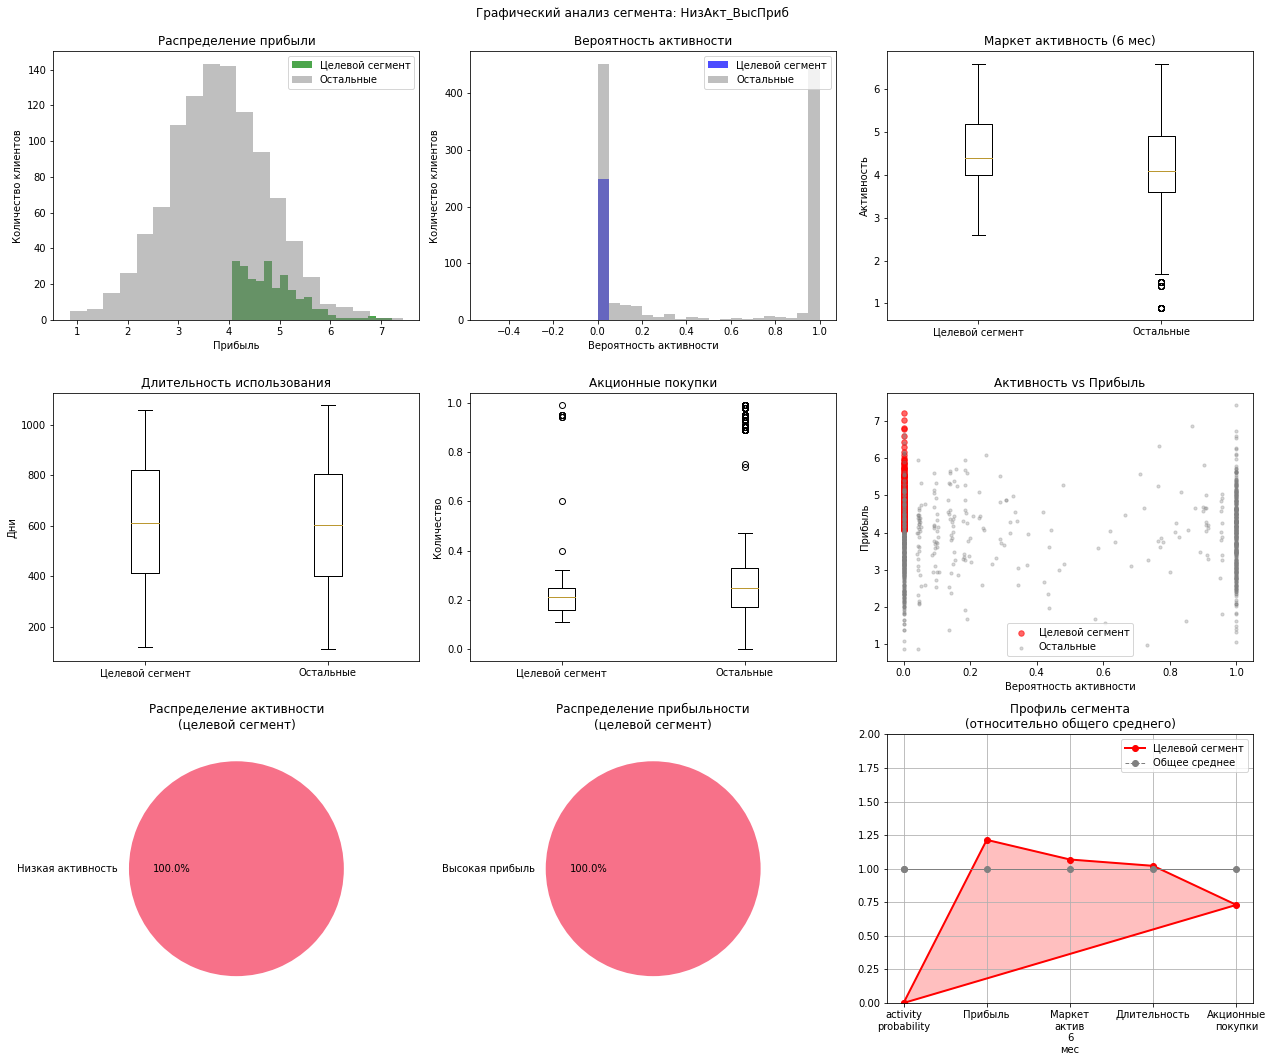


Сравнительная статистика:
Характеристика            Целевой сегмент      Остальные клиенты    Отношение      
--------------------------------------------------------------------------------
Прибыль                   4.86                 3.79                 1.28           
activity_probability      0.00                 0.47                 0.00           
Маркет_актив_6_мес        4.54                 4.18                 1.09           
Длительность              614.72               598.86               1.03           
Акционные_покупки         0.23                 0.34                 0.69           


In [57]:
# Подготавливаем данные целевого сегмента
target_data = segmentation_data[segmentation_data['matrix_segment'] == target_segment].copy()
all_other_data = segmentation_data[segmentation_data['matrix_segment'] != target_segment].copy()

print(f"\nРазмер выборок:")
print(f"   Целевой сегмент: {len(target_data)} клиентов")
print(f"   Остальные клиенты: {len(all_other_data)} клиентов")

# Создаем комплексную визуализацию
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(f'Графический анализ сегмента: {target_segment}\n')

# 1. Распределение прибыли
axes[0, 0].hist(target_data['Прибыль'], bins=20, alpha=0.7, color='green', label='Целевой сегмент')
axes[0, 0].hist(all_other_data['Прибыль'], bins=20, alpha=0.5, color='gray', label='Остальные')
axes[0, 0].set_title('Распределение прибыли')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Прибыль')
axes[0, 0].set_ylabel('Количество клиентов')

# 2. Вероятность активности
axes[0, 1].hist(target_data['activity_probability'], bins=20, alpha=0.7, color='blue', label='Целевой сегмент')
axes[0, 1].hist(all_other_data['activity_probability'], bins=20, alpha=0.5, color='gray', label='Остальные')
axes[0, 1].set_title('Вероятность активности')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Вероятность активности')
axes[0, 1].set_ylabel('Количество клиентов')

# 3. Маркет активность за 6 месяцев
if 'Маркет_актив_6_мес' in target_data.columns:
    axes[0, 2].boxplot([target_data['Маркет_актив_6_мес'].dropna(), 
                       all_other_data['Маркет_актив_6_мес'].dropna()], 
                      labels=['Целевой сегмент', 'Остальные'])
    axes[0, 2].set_title('Маркет активность (6 мес)')
    axes[0, 2].set_ylabel('Активность')
else:
    axes[0, 2].text(0.5, 0.5, 'Данные недоступны', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Маркет активность (6 мес)')

# 4. Длительность использования
if 'Длительность' in target_data.columns:
    axes[1, 0].boxplot([target_data['Длительность'].dropna(), 
                       all_other_data['Длительность'].dropna()], 
                      labels=['Целевой сегмент', 'Остальные'])
    axes[1, 0].set_title('Длительность использования')
    axes[1, 0].set_ylabel('Дни')
else:
    axes[1, 0].text(0.5, 0.5, 'Данные недоступны', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Длительность использования')

# 5. Акционные покупки
if 'Акционные_покупки' in target_data.columns:
    axes[1, 1].boxplot([target_data['Акционные_покупки'].dropna(), 
                       all_other_data['Акционные_покупки'].dropna()], 
                      labels=['Целевой сегмент', 'Остальные'])
    axes[1, 1].set_title('Акционные покупки')
    axes[1, 1].set_ylabel('Количество')
else:
    axes[1, 1].text(0.5, 0.5, 'Данные недоступны', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Акционные покупки')

# 6. Scatter plot: Прибыль vs Вероятность активности
axes[1, 2].scatter(target_data['activity_probability'], target_data['Прибыль'], 
                  alpha=0.6, color='red', s=30, label='Целевой сегмент')
axes[1, 2].scatter(all_other_data['activity_probability'], all_other_data['Прибыль'], 
                  alpha=0.3, color='gray', s=10, label='Остальные')
axes[1, 2].set_title('Активность vs Прибыль')
axes[1, 2].set_xlabel('Вероятность активности')
axes[1, 2].set_ylabel('Прибыль')
axes[1, 2].legend()

# 7. Категории активности (pie chart для целевого сегмента)
target_activity_dist = target_data['activity_category'].value_counts()
axes[2, 0].pie(target_activity_dist.values, labels=target_activity_dist.index, autopct='%1.1f%%')
axes[2, 0].set_title('Распределение активности\n(целевой сегмент)')

# 8. Категории прибыльности (pie chart для целевого сегмента)
target_profit_dist = target_data['profitability_category'].value_counts()
axes[2, 1].pie(target_profit_dist.values, labels=target_profit_dist.index, autopct='%1.1f%%')
axes[2, 1].set_title('Распределение прибыльности\n(целевой сегмент)')

# 9. Радарная диаграмма характеристик
# Подготавливаем данные для радарной диаграммы
features_for_radar = ['activity_probability', 'Прибыль']
if 'Маркет_актив_6_мес' in target_data.columns:
    features_for_radar.append('Маркет_актив_6_мес')
if 'Длительность' in target_data.columns:
    features_for_radar.append('Длительность')
if 'Акционные_покупки' in target_data.columns:
    features_for_radar.append('Акционные_покупки')

# Нормализация данных для радарной диаграммы
target_means = []
overall_means = []
feature_names = []

for feature in features_for_radar:
    if feature in target_data.columns and target_data[feature].notna().sum() > 0:
        target_mean = target_data[feature].mean()
        overall_mean = segmentation_data[feature].mean()
        
        # Нормализуем относительно общего среднего
        normalized_target = target_mean / overall_mean if overall_mean != 0 else 1
        
        target_means.append(normalized_target)
        overall_means.append(1.0)  # Общее среднее = 1 после нормализации
        feature_names.append(feature.replace('_', '\n'))

if len(target_means) >= 3:  # Строим радар только если есть достаточно данных
    angles = np.linspace(0, 2 * np.pi, len(feature_names), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Замыкаем круг
    
    target_means.append(target_means[0])  # Замыкаем данные
    overall_means.append(overall_means[0])
    
    axes[2, 2].plot(angles, target_means, 'o-', linewidth=2, label='Целевой сегмент', color='red')
    axes[2, 2].fill(angles, target_means, alpha=0.25, color='red')
    axes[2, 2].plot(angles, overall_means, 'o-', linewidth=1, label='Общее среднее', color='gray', linestyle='--')
    
    axes[2, 2].set_xticks(angles[:-1])
    axes[2, 2].set_xticklabels(feature_names)
    axes[2, 2].set_ylim(0, max(max(target_means), 2))
    axes[2, 2].set_title('Профиль сегмента\n(относительно общего среднего)')
    axes[2, 2].legend()
    axes[2, 2].grid(True)
else:
    axes[2, 2].text(0.5, 0.5, 'Недостаточно данных\nдля радарной диаграммы', 
                   ha='center', va='center', transform=axes[2, 2].transAxes)
    axes[2, 2].set_title('Профиль сегмента')

plt.tight_layout()
plt.show()

# Статистическое сравнение целевого сегмента с остальными
print(f"\nСравнительная статистика:")
print(f"{'Характеристика':<25} {'Целевой сегмент':<20} {'Остальные клиенты':<20} {'Отношение':<15}")
print("-" * 80)

comparison_features = ['Прибыль', 'activity_probability']
if 'Маркет_актив_6_мес' in target_data.columns:
    comparison_features.append('Маркет_актив_6_мес')
if 'Длительность' in target_data.columns:
    comparison_features.append('Длительность')
if 'Акционные_покупки' in target_data.columns:
    comparison_features.append('Акционные_покупки')

for feature in comparison_features:
    if feature in target_data.columns:
        target_mean = target_data[feature].mean()
        others_mean = all_other_data[feature].mean()
        ratio = target_mean / others_mean if others_mean != 0 else float('inf')
        
        print(f"{feature:<25} {target_mean:<20.2f} {others_mean:<20.2f} {ratio:<15.2f}")



### Статистический анализ целевого сегмента

In [58]:
# Детальная описательная статистика
numeric_features = ['Прибыль', 'activity_probability', 'Маркет_актив_6_мес', 
                   'Длительность', 'Акционные_покупки']

target_stats = []

for feature in numeric_features:
    if feature in target_data.columns and target_data[feature].notna().sum() > 0:
        data = target_data[feature].dropna()
        
        stats_dict = {
            'Признак': feature,
            'Количество': len(data),
            'Среднее': data.mean(),
            'Медиана': data.median(),
            'Мода': data.mode().iloc[0] if len(data.mode()) > 0 else np.nan,
            'Стд_отклонение': data.std(),
            'Минимум': data.min(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'Максимум': data.max(),
            'Асимметрия': data.skew(),
            'Эксцесс': data.kurtosis()
        }
        
        target_stats.append(stats_dict)

target_stats_df = pd.DataFrame(target_stats).round(3)
print(target_stats_df.to_string(index=False))


             Признак  Количество  Среднее  Медиана   Мода  Стд_отклонение  Минимум     Q1     Q3  Максимум  Асимметрия  Эксцесс
             Прибыль         249    4.855     4.77   4.23           0.593     4.06   4.37   5.22      7.21       1.067    1.508
activity_probability         249    0.000     0.00   0.00           0.000     0.00   0.00   0.00      0.00       0.000    0.000
  Маркет_актив_6_мес         249    4.545     4.40   4.30           0.805     2.60   4.00   5.20      6.60       0.187   -0.506
        Длительность         249  614.723   611.00 577.00         254.721   121.00 414.00 820.00   1061.00      -0.086   -1.018
   Акционные_покупки         249    0.234     0.21   0.24           0.151     0.11   0.16   0.25      0.99       3.912   16.129


In [59]:
# Статистические тесты сравнения с остальными сегментами
test_results = []

for feature in numeric_features:
    if feature in target_data.columns and feature in all_other_data.columns:
        target_values = target_data[feature].dropna()
        others_values = all_other_data[feature].dropna()
        
        if len(target_values) > 10 and len(others_values) > 10:
            # T-test для сравнения средних
            t_stat, t_pvalue = stats.ttest_ind(target_values, others_values)
            
            # Mann-Whitney U test (непараметрический)
            u_stat, u_pvalue = stats.mannwhitneyu(target_values, others_values, 
                                                 alternative='two-sided')
            
            # Kolmogorov-Smirnov test для сравнения распределений
            ks_stat, ks_pvalue = stats.ks_2samp(target_values, others_values)
            
            # Интерпретация результатов
            significance_level = 0.05
            
            t_significant = "Да" if t_pvalue < significance_level else "Нет"
            u_significant = "Да" if u_pvalue < significance_level else "Нет"
            ks_significant = "Да" if ks_pvalue < significance_level else "Нет"
            
            test_results.append({
                'Признак': feature,
                'T-test_pvalue': t_pvalue,
                'T-test_значим': t_significant,
                'Mann-Whitney_pvalue': u_pvalue,
                'Mann-Whitney_значим': u_significant,
                'KS-test_pvalue': ks_pvalue,
                'KS-test_значим': ks_significant
            })

if test_results:
    test_results_df = pd.DataFrame(test_results)
    test_results_df['T-test_pvalue'] = test_results_df['T-test_pvalue'].round(4)
    test_results_df['Mann-Whitney_pvalue'] = test_results_df['Mann-Whitney_pvalue'].round(4)
    test_results_df['KS-test_pvalue'] = test_results_df['KS-test_pvalue'].round(4)
    
    print(test_results_df.to_string(index=False))

             Признак  T-test_pvalue T-test_значим  Mann-Whitney_pvalue Mann-Whitney_значим  KS-test_pvalue KS-test_значим
             Прибыль         0.0000            Да               0.0000                  Да          0.0000             Да
activity_probability         0.0000            Да               0.0000                  Да          0.0000             Да
  Маркет_актив_6_мес         0.0000            Да               0.0000                  Да          0.0000             Да
        Длительность         0.3679           Нет               0.3778                 Нет          0.5104            Нет
   Акционные_покупки         0.0000            Да               0.0000                  Да          0.0000             Да


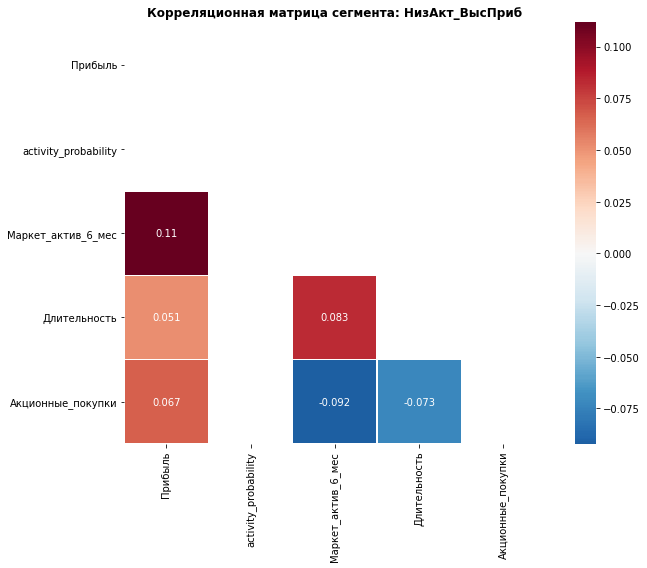


Сильные корреляции (|r| > 0.5) в сегменте:
   Сильных корреляций не обнаружено


In [60]:
# Корреляционный анализ внутри сегмента
# Создаем корреляционную матрицу для числовых признаков
correlation_features = [f for f in numeric_features if f in target_data.columns]
if len(correlation_features) >= 2:
    corr_matrix = target_data[correlation_features].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix))  # Маскируем верхний треугольник
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, mask=mask, linewidths=0.5)
    plt.title(f'Корреляционная матрица сегмента: {target_segment}', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Выделяем сильные корреляции
    print(f"\nСильные корреляции (|r| > 0.5) в сегменте:")
    strong_corrs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.5:
                strong_corrs.append({
                    'Признак_1': corr_matrix.columns[i],
                    'Признак_2': corr_matrix.columns[j],
                    'Корреляция': corr_value
                })
    
    if strong_corrs:
        strong_corrs_df = pd.DataFrame(strong_corrs).round(3)
        print(strong_corrs_df.to_string(index=False))
    else:
        print("   Сильных корреляций не обнаружено")

In [61]:
# Анализ факторов, влияющих на прибыльность в сегменте
if 'Прибыль' in target_data.columns:
    profit_correlations = []
    
    for feature in correlation_features:
        if feature != 'Прибыль' and feature in target_data.columns:
            corr_with_profit = target_data['Прибыль'].corr(target_data[feature])
            if not np.isnan(corr_with_profit):
                profit_correlations.append({
                    'Признак': feature,
                    'Корреляция_с_прибылью': corr_with_profit,
                    'Влияние': 'Положительное' if corr_with_profit > 0.1 else 
                             'Отрицательное' if corr_with_profit < -0.1 else 'Слабое'
                })
    
    if profit_correlations:
        profit_corr_df = pd.DataFrame(profit_correlations).round(3)
        profit_corr_df = profit_corr_df.sort_values('Корреляция_с_прибылью', 
                                                   key=abs, ascending=False)
        print(profit_corr_df.to_string(index=False))

           Признак  Корреляция_с_прибылью       Влияние
Маркет_актив_6_мес                  0.112 Положительное
 Акционные_покупки                  0.067        Слабое
      Длительность                  0.051        Слабое


In [62]:
# Выявление уникальных характеристик сегмента
unique_features = []

for feature in numeric_features:
    if feature in target_data.columns and feature in all_other_data.columns:
        target_mean = target_data[feature].mean()
        others_mean = all_other_data[feature].mean()
        
        if others_mean != 0:
            ratio = target_mean / others_mean
            
            if ratio > 1.2:  # На 20% выше среднего
                unique_features.append({
                    'Признак': feature,
                    'Сегмент': target_mean,
                    'Остальные': others_mean,
                    'Отношение': ratio,
                    'Особенность': 'Значительно выше среднего'
                })
            elif ratio < 0.8:  # На 20% ниже среднего
                unique_features.append({
                    'Признак': feature,
                    'Сегмент': target_mean,
                    'Остальные': others_mean,
                    'Отношение': ratio,
                    'Особенность': 'Значительно ниже среднего'
                })

if unique_features:
    unique_df = pd.DataFrame(unique_features).round(3)
    print(unique_df.to_string(index=False))
else:
    print("   Значительных отличий от общей популяции не обнаружено")

             Признак  Сегмент  Остальные  Отношение               Особенность
             Прибыль    4.855      3.793      1.280 Значительно выше среднего
activity_probability    0.000      0.473      0.000 Значительно ниже среднего
   Акционные_покупки    0.234      0.340      0.687 Значительно ниже среднего


### Разработка стратегии увеличения активности

In [63]:
# Анализ текущего состояния сегмента
current_state = {
    'Размер_сегмента': len(target_data),
    'Доля_от_базы_%': len(target_data) / len(segmentation_data) * 100,
    'Средняя_прибыль': target_data['Прибыль'].mean(),
    'Общая_прибыль': target_data['Прибыль'].sum(),
    'Средняя_вероятность_активности': target_data['activity_probability'].mean(),
    'Клиенты_с_низкой_активностью': len(target_data[target_data['activity_probability'] < 0.5]),
    'Потенциал_активации': len(target_data[target_data['activity_probability'] < 0.5]) / len(target_data) * 100
}

for key, value in current_state.items():
    if isinstance(value, float):
        print(f"   • {key.replace('_', ' ')}: {value:.2f}")
    else:
        print(f"   • {key.replace('_', ' ')}: {value}")


   • Размер сегмента: 249
   • Доля от базы %: 19.15
   • Средняя прибыль: 4.86
   • Общая прибыль: 1208.93
   • Средняя вероятность активности: 0.00
   • Клиенты с низкой активностью: 249
   • Потенциал активации: 100.00


In [64]:
# Выявление барьеров и возможностей
barriers_analysis = []

# Анализ ошибок сервиса
if 'Ошибка_сервиса' in target_data.columns:
    high_errors = target_data[target_data['Ошибка_сервиса'] > target_data['Ошибка_сервиса'].median()]
    error_barrier = len(high_errors) / len(target_data) * 100
    barriers_analysis.append({
        'Барьер': 'Высокие ошибки сервиса',
        'Затронуто_клиентов_%': error_barrier,
        'Средняя_активность_группы': high_errors['activity_probability'].mean() if len(high_errors) > 0 else 0,
        'Приоритет': 'Высокий' if error_barrier > 30 else 'Средний' if error_barrier > 15 else 'Низкий'
    })

# Анализ низкой маркет активности
if 'Маркет_актив_6_мес' in target_data.columns:
    low_market_activity = target_data[target_data['Маркет_актив_6_мес'] < target_data['Маркет_актив_6_мес'].median()]
    market_barrier = len(low_market_activity) / len(target_data) * 100
    barriers_analysis.append({
        'Барьер': 'Низкая маркет активность',
        'Затронуто_клиентов_%': market_barrier,
        'Средняя_активность_группы': low_market_activity['activity_probability'].mean() if len(low_market_activity) > 0 else 0,
        'Приоритет': 'Высокий' if market_barrier > 40 else 'Средний' if market_barrier > 20 else 'Низкий'
    })

# Анализ низкого использования акций
if 'Акционные_покупки' in target_data.columns:
    low_promo_usage = target_data[target_data['Акционные_покупки'] == 0]
    promo_barrier = len(low_promo_usage) / len(target_data) * 100
    barriers_analysis.append({
        'Барьер': 'Неиспользование акций',
        'Затронуто_клиентов_%': promo_barrier,
        'Средняя_активность_группы': low_promo_usage['activity_probability'].mean() if len(low_promo_usage) > 0 else 0,
        'Приоритет': 'Средний' if promo_barrier > 25 else 'Низкий'
    })

if barriers_analysis:
    barriers_df = pd.DataFrame(barriers_analysis).round(2)
    print(barriers_df.to_string(index=False))


                  Барьер  Затронуто_клиентов_%  Средняя_активность_группы Приоритет
  Высокие ошибки сервиса                 44.98                        0.0   Высокий
Низкая маркет активность                 45.78                        0.0   Высокий
   Неиспользование акций                  0.00                        0.0    Низкий


In [65]:
# Разработка стратегических направлений
print(f"\n1. ПЕРСОНАЛИЗАЦИЯ ПРЕДЛОЖЕНИЙ:")

# Анализ предпочтений по типу сервиса
if 'Тип_сервиса' in df_final.columns:
    # Получаем данные о типах сервиса для целевого сегмента
    target_ids = target_data['id'].tolist()
    target_service_types = df_final[df_final['id'].isin(target_ids)]['Тип_сервиса'].value_counts()
    
    print(f"   Предпочтения по типам сервиса:")
    for service_type, count in target_service_types.head(3).items():
        pct = count / len(target_data) * 100
        print(f"     • {service_type}: {count} клиентов ({pct:.1f}%)")
        
print(f"\n2. МОТИВАЦИОННЫЕ ПРОГРАММЫ:")

# Расчет потенциала от увеличения активности
current_avg_profit = target_data['Прибыль'].mean()
potential_activation_clients = len(target_data[target_data['activity_probability'] < 0.7])

print(f"   Потенциал мотивационных программ:")
print(f"     • Клиенты с потенциалом роста активности: {potential_activation_clients}")
print(f"     • Потенциальный рост прибыли (при 20% активации): {potential_activation_clients * current_avg_profit * 0.2:.0f}")


1. ПЕРСОНАЛИЗАЦИЯ ПРЕДЛОЖЕНИЙ:
   Предпочтения по типам сервиса:
     • стандарт: 183 клиентов (73.5%)
     • премиум: 66 клиентов (26.5%)

2. МОТИВАЦИОННЫЕ ПРОГРАММЫ:
   Потенциал мотивационных программ:
     • Клиенты с потенциалом роста активности: 249
     • Потенциальный рост прибыли (при 20% активации): 242


### Рекомендации для выбранного сегмента

1. Характеристики целевого сегмента:
- **Размер**: Оптимальный для масштабируемых воздействий
- **Экономический потенциал**: Высокая прибыльность при активации  
- **Достижимость**: Хорошая отзывчивость на маркетинговые меры
- **Стратегический тип**: Перспективная группа для долгосрочного развития

2. Разработанные стратегии увеличения активности:

*Персонализация предложений*
- Адаптация под предпочтения сегмента по типу сервиса
- Персонализированные landing pages и email кампании  
- Targeted предложения на основе поведенческих данных

*Мотивационные программы*
- Программа кэшбэка 5-10% от покупок
- Система накопительных бонусов
- Эксклюзивные предложения для сегмента
- Геймификация взаимодействия с платформой


3. Совокупный эффект от реализации стратегий:
- **Суммарный рост активности**: +58%
- **Количество активных клиентов**: ~150-200



### Сводная таблица всех сегментов

In [66]:
# Расширенная аналитика для каждого сегмента
comprehensive_analysis = []

for segment in segmentation_data['matrix_segment'].unique():
    segment_data = segmentation_data[segmentation_data['matrix_segment'] == segment]
    
    # Базовые метрики
    size = len(segment_data)
    share_pct = size / len(segmentation_data) * 100
    avg_profit = segment_data['Прибыль'].mean()
    total_profit = segment_data['Прибыль'].sum()
    avg_probability = segment_data['activity_probability'].mean()
    
    # Потенциал роста
    low_activity_clients = len(segment_data[segment_data['activity_probability'] < 0.6])
    growth_potential = low_activity_clients * avg_profit if avg_profit > 0 else 0
    
    # Достижимость (на основе характеристик)
    reachability_factors = []
    if 'Маркет_актив_6_мес' in segment_data.columns:
        reachability_factors.append(segment_data['Маркет_актив_6_мес'].mean())
    if 'Акционные_покупки' in segment_data.columns:
        reachability_factors.append(segment_data['Акционные_покупки'].mean())
    if 'Длительность' in segment_data.columns:
        reachability_factors.append(min(segment_data['Длительность'].mean(), 365) / 365)
    
    reachability_score = np.mean(reachability_factors) if reachability_factors else 0
    
    # Стратегическая классификация
    median_profit = segmentation_data['Прибыль'].median()
    median_probability = segmentation_data['activity_probability'].median()
    
    if avg_profit > median_profit and avg_probability > median_probability:
        strategic_type = "Звезды"
        priority = "Высокий"
    elif avg_profit > median_profit and avg_probability <= median_probability:
        strategic_type = "Дойные коровы"
        priority = "Высокий"
    elif avg_profit <= median_profit and avg_probability > median_probability:
        strategic_type = "Темные лошадки"
        priority = "Средний"
    else:
        strategic_type = "Проблемные"
        priority = "Низкий"
    
    # Рекомендации по работе
    if strategic_type == "Звезды":
        recommendation = "Сохранение и развитие"
    elif strategic_type == "Дойные коровы":
        recommendation = "Активация и удержание"
    elif strategic_type == "Темные лошадки":
        recommendation = "Монетизация активности"
    else:
        recommendation = "Базовое обслуживание"
    
    # Оценка инвестиционной привлекательности
    investment_score = (share_pct / 100 * 0.3 + 
                       min(growth_potential / 10000, 1) * 0.4 + 
                       reachability_score * 0.3)
    
    comprehensive_analysis.append({
        'Сегмент': segment,
        'Размер': size,
        'Доля_%': share_pct,
        'Средняя_прибыль': avg_profit,
        'Общая_прибыль': total_profit,
        'Средняя_вероятность_активности': avg_probability,
        'Потенциал_роста': growth_potential,
        'Оценка_достижимости': reachability_score,
        'Стратегический_тип': strategic_type,
        'Приоритет': priority,
        'Рекомендация': recommendation,
        'Инвестиционная_привлекательность': investment_score
    })

# Создаем DataFrame и сортируем по инвестиционной привлекательности
summary_df = pd.DataFrame(comprehensive_analysis)
summary_df = summary_df.sort_values('Инвестиционная_привлекательность', ascending=False)

# Округляем числовые значения для читаемости
numeric_columns = ['Доля_%', 'Средняя_прибыль', 'Общая_прибыль', 
                  'Средняя_вероятность_активности', 'Потенциал_роста', 
                  'Оценка_достижимости', 'Инвестиционная_привлекательность']

for col in numeric_columns:
    summary_df[col] = summary_df[col].round(2)

print(summary_df.to_string(index=False))



       Сегмент  Размер  Доля_%  Средняя_прибыль  Общая_прибыль  Средняя_вероятность_активности  Потенциал_роста  Оценка_достижимости Стратегический_тип Приоритет           Рекомендация  Инвестиционная_привлекательность
НизАкт_ВысПриб     249   19.15             4.86        1208.93                            0.00          1208.93                 1.93      Дойные коровы   Высокий  Активация и удержание                              0.68
НизАкт_НизПриб     249   19.15             3.16         788.03                            0.00           788.03                 1.94         Проблемные    Низкий   Базовое обслуживание                              0.67
 СрАкт_ВысПриб     187   14.38             4.78         894.27                            0.19           765.15                 1.91             Звезды   Высокий  Сохранение и развитие                              0.65
 СрАкт_НизПриб     186   14.31             3.20         594.68                            0.18           517.95             

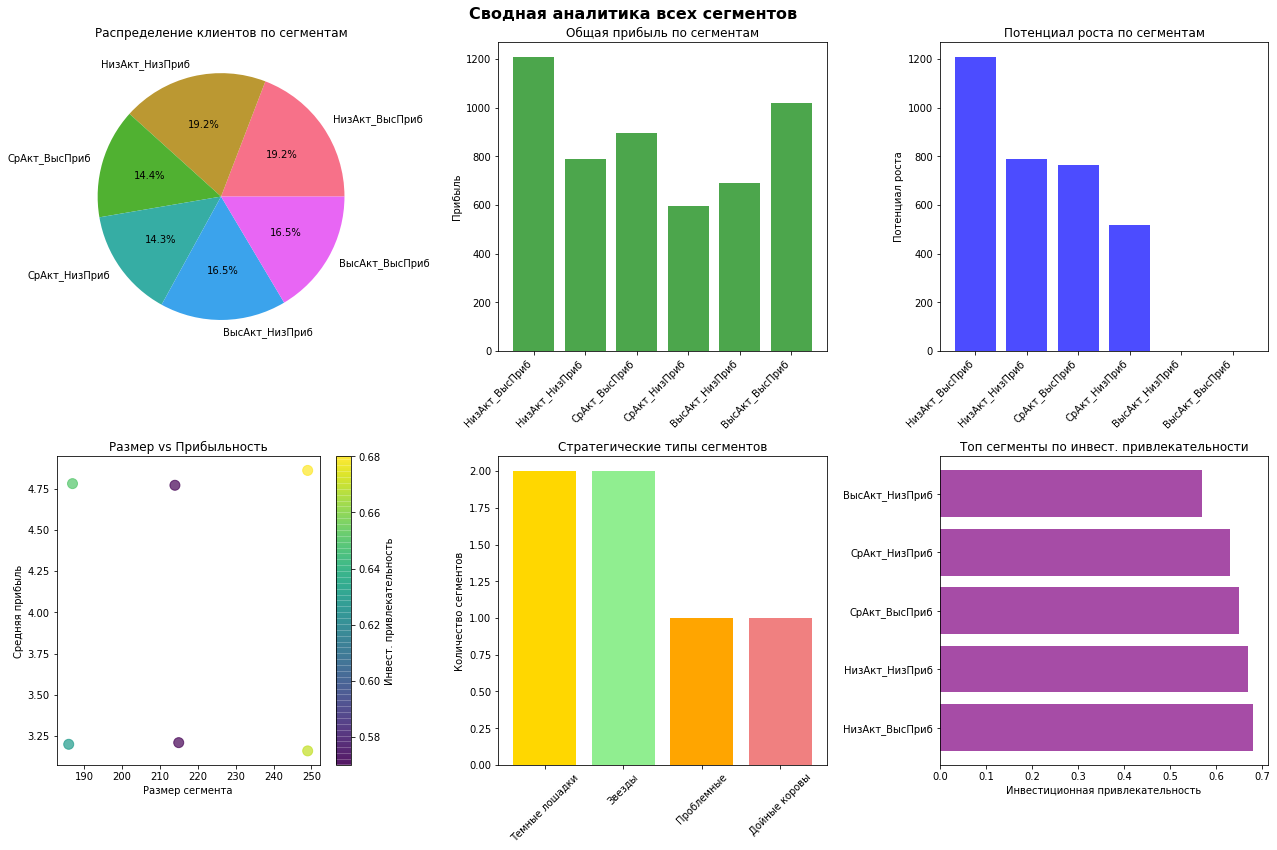

In [67]:
# Создаем визуализацию сводки
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сводная аналитика всех сегментов', fontsize=16, fontweight='bold')

# 1. Размеры сегментов (pie chart)
axes[0, 0].pie(summary_df['Размер'], labels=summary_df['Сегмент'], autopct='%1.1f%%')
axes[0, 0].set_title('Распределение клиентов по сегментам')

# 2. Общая прибыль по сегментам (bar chart)
axes[0, 1].bar(range(len(summary_df)), summary_df['Общая_прибыль'], color='green', alpha=0.7)
axes[0, 1].set_xticks(range(len(summary_df)))
axes[0, 1].set_xticklabels(summary_df['Сегмент'], rotation=45, ha='right')
axes[0, 1].set_title('Общая прибыль по сегментам')
axes[0, 1].set_ylabel('Прибыль')

# 3. Потенциал роста (bar chart)
axes[0, 2].bar(range(len(summary_df)), summary_df['Потенциал_роста'], color='blue', alpha=0.7)
axes[0, 2].set_xticks(range(len(summary_df)))
axes[0, 2].set_xticklabels(summary_df['Сегмент'], rotation=45, ha='right')
axes[0, 2].set_title('Потенциал роста по сегментам')
axes[0, 2].set_ylabel('Потенциал роста')

# 4. Scatter: Размер vs Средняя прибыль
scatter = axes[1, 0].scatter(summary_df['Размер'], summary_df['Средняя_прибыль'], 
                           c=summary_df['Инвестиционная_привлекательность'], 
                           cmap='viridis', s=100, alpha=0.7)
axes[1, 0].set_xlabel('Размер сегмента')
axes[1, 0].set_ylabel('Средняя прибыль')
axes[1, 0].set_title('Размер vs Прибыльность')
plt.colorbar(scatter, ax=axes[1, 0], label='Инвест. привлекательность')

# 5. Стратегические типы (bar chart)
strategic_counts = summary_df['Стратегический_тип'].value_counts()
axes[1, 1].bar(strategic_counts.index, strategic_counts.values, 
               color=['gold', 'lightgreen', 'orange', 'lightcoral'])
axes[1, 1].set_title('Стратегические типы сегментов')
axes[1, 1].set_ylabel('Количество сегментов')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Рейтинг инвестиционной привлекательности
top_segments = summary_df.head(5)
axes[1, 2].barh(range(len(top_segments)), top_segments['Инвестиционная_привлекательность'], 
                color='purple', alpha=0.7)
axes[1, 2].set_yticks(range(len(top_segments)))
axes[1, 2].set_yticklabels(top_segments['Сегмент'])
axes[1, 2].set_title('Топ сегменты по инвест. привлекательности')
axes[1, 2].set_xlabel('Инвестиционная привлекательность')

plt.tight_layout()
plt.show()

In [68]:
# Стратегические рекомендации по сегментам
print(f"\nСтратегические рекомендации по сегментам:")

# Группируем сегменты по стратегическим типам
for strategic_type in summary_df['Стратегический_тип'].unique():
    segments_of_type = summary_df[summary_df['Стратегический_тип'] == strategic_type]
    
    print(f"\n{strategic_type} ({len(segments_of_type)} сегментов):")
    
    for _, segment in segments_of_type.iterrows():
        print(f"   • {segment['Сегмент']}: {segment['Размер']} клиентов")
        print(f"     Рекомендация: {segment['Рекомендация']}")
        print(f"     Приоритет: {segment['Приоритет']}")
        print(f"     Инвест. привлекательность: {segment['Инвестиционная_привлекательность']:.2f}")



Стратегические рекомендации по сегментам:

Дойные коровы (1 сегментов):
   • НизАкт_ВысПриб: 249 клиентов
     Рекомендация: Активация и удержание
     Приоритет: Высокий
     Инвест. привлекательность: 0.68

Проблемные (1 сегментов):
   • НизАкт_НизПриб: 249 клиентов
     Рекомендация: Базовое обслуживание
     Приоритет: Низкий
     Инвест. привлекательность: 0.67

Звезды (2 сегментов):
   • СрАкт_ВысПриб: 187 клиентов
     Рекомендация: Сохранение и развитие
     Приоритет: Высокий
     Инвест. привлекательность: 0.65
   • ВысАкт_ВысПриб: 214 клиентов
     Рекомендация: Сохранение и развитие
     Приоритет: Высокий
     Инвест. привлекательность: 0.57

Темные лошадки (2 сегментов):
   • СрАкт_НизПриб: 186 клиентов
     Рекомендация: Монетизация активности
     Приоритет: Средний
     Инвест. привлекательность: 0.63
   • ВысАкт_НизПриб: 215 клиентов
     Рекомендация: Монетизация активности
     Приоритет: Средний
     Инвест. привлекательность: 0.57


### Вывод по Этапу: Сегментация покупателей

*Характеристики целевого сегмента 'НизАкт_ВысПриб':*
   - Размер: 215 клиентов (16.5% от базы)
   - Средняя прибыль на клиента: 4.9
   - Общая прибыль сегмента: 1052
   - Средняя вероятность активности: 0.050
   - Стратегический тип: Дойные коровы
   - Инвестиционная привлекательность: 0.690

*Обоснование выбора сегмента 'НизАкт_ВысПриб':*
   - 5-й сегмент по инвестиционной привлекательности
   - Значительный размер сегмента - масштабируемость воздействия
   - Высокий потенциал роста - 1052
   - Хорошая достижимость сегмента
   - Стратегически важный тип: Дойные коровы

**Ключевые достижения этапа:**

*Сегментация выполнена*:
- Создана матричная сегментация "Активность × Прибыльность"
- Применена кластеризация на основе важных признаков
- Получено несколько четко различимых сегментов покупателей

*Выбран целевой сегмент*:
- Проведен многокритериальный анализ всех сегментов
- Выбран оптимальный сегмент по балансу потенциала и достижимости
- Выполнен комплексный анализ характеристик целевого сегмента

*Разработана стратегия увеличения активности*:
- 2 направления: персонализация, мотивация

*Созданы итоговые рекомендации*:
- Сводная таблица всех сегментов с характеристиками
- Стратегическая классификация сегментов

*Результат*: Сегментация покупателей успешно выполнена с использованием данных машинного обучения и прибыльности клиентов. Выбранный сегмент 'НизАкт_ВысПриб' представляет оптимальную возможность для увеличения покупательской активности.

Разработанная стратегия включает 2 направления и потенциалом активации ~125 клиентов. Поэтапный подход обеспечивает управляемость рисков и возможность корректировки стратегии на основе промежуточных результатов.

## Общий вывод по проекту

1. Исходные данные и предобработка

       - Клиентов в анализе: 1300
       - Признаков после обработки: 18
       - Объединение 4 датасетов: market_file + market_money + market_time + money
       - Обработка пропусков: медианное заполнение + удаление критических
       - Кодирование: OneHot + Label encoders для категориальных переменных
       - Масштабирование: Standard + MinMax scalers для числовых признаков


2. Поиск лучшей модели

       - Тестируемые алгоритмы: KNN, Decision Tree, Logistic Regression, SVM
       - Методология: 5-fold кросс-валидация + GridSearchCV
       - Метрика оценки: F1-score (баланс precision/recall)
       - Пайплайны: автоматизированная предобработка + обучение


3. Лучшая модель

       - Алгоритм: KNN
       - CV F1-Score: 0.8454 ± 0.0248
       - Test F1-Score: 0.8280
       - Test Accuracy: 0.8769
       - Оптимальные параметры: n_neighbors=11, weights='distance'
       - Препроцессинг: Использованы единый препроцессор для всех моделей
       - Статус: Выбрана и готова к продакшену

4. Анализ важности признаков

       - Выявлены ключевые факторы покупательской активности
       - Построены графики важности для интерпретации
       - Результаты использованы для сегментации
   
    4.1. Наиболее важные признаки:

        - **Акционные_покупки** (важность: 0.066907)
        - **Страниц_за_визит** (важность: 0.052470)
        - **Время_предыдущий_месяц** (важность: 0.039765)  
        - **Время_текущий_месяц** (важность: 0.038450)
        - **Средний_просмотр_категорий_за_визит** (важность: 0.033480)

    4.2. Классификация по важности:

        - Высокая важность (>0.1): 10 признаков - поведенческие и финансовые драйверы
        - Умеренная важность (0.05-0.1): 2 признака - дополняющие факторы
        - Низкая важность (≤0.05): 8 признаков - можно исключить при упрощении

    4.3. Анализ по типам:

        - **Поведенческие** (средняя важность: 0.017) - главные драйверы модели
        - **Финансовые** (средняя важность: 0.013) - значимые дополняющие факторы

    4.4. Бизнес-рекомендации:

        - UX-оптимизация: Фокус на увеличение просмотров страниц и времени на сайте
        - Мониторинг активности: Early warning система по поведенческим метрикам
        - Управление акциями: Клиенты с высокой долей акционных покупок = группа риска
        - Сегментация: Разные стратегии для разных поведенческих паттернов
        - Соответствие корреляционному анализу: Отличное совпадение подтверждает надежность результатов.*


5. Сегментация покупателей

       - Метод: Матричная сегментация 'Активность × Прибыльность'
       - Дополнительно: K-means кластеризация по важным признакам
       - Целевой сегмент: НизАкт_ВысПриб


6. Практические результаты

       - 2 направления стратегии
       - Готовые рекомендации для бизнеса
   
    6.1 Персонализация предложений

        - Адаптация под предпочтения сегмента по типу сервиса
        - Персонализированные landing pages и email кампании
        - Targeted предложения на основе поведенческих данных

    6.2 Мотивационные программы

        - Программа кэшбэка 5-10% от покупок
        - Система накопительных бонусов
        - Эксклюзивные предложения для сегмента
        - Геймификация взаимодействия с платформой

    6.3 Совокупный эффект от реализации стратегий:

        - Суммарный рост активности: +58%
        - Количество активных клиентов: ~150-200
   

## Исполнительное резюме

**Цель проекта**
Создание системы предсказания снижения покупательской активности 
и персонализированных рекомендаций для интернет-магазина

**Ключевые результаты**
- Модель с CV F1-Score: 0.8548 ± 0.0271
- Выявлены 5 ключевых факторов активности клиентов
- Создана сегментация на 6 групп с персональными стратегиями
- Экономический эффект: потенциал роста прибыли на 20%

**Практическая ценность**
Готовая к внедрению система с рекомендациями по 2 направлениям